Routines used to loop through image lists and print out information.

Also includes a routine to check for saturation, but need to have pixel mask (which can be made in Data_reduction_pipeline.ipynb) and need to analyze raw data.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.ndimage import filters

In [4]:
# Directory and list of images to examine. Generally, image list here is all raw images in a given directory.
# To make image lists, pipe output of ls into a file (e.g. ls *FIT > imlist)

directory = '/Users/dahlek/Desktop/2017-03-26/' 
jupiter = np.loadtxt(directory+'imlist',dtype=str)

In [6]:
# Print given keywords of interest for each file. Here, I'm printing the name of the file, whether that image is RF-on (1) or RF-off (0), the wavelength, the exposure time, and the UT date it was recorded
# This allows the user to find the beginning and end of a given datacube - this information can be used below to copy and paste a cube list into a new text file.

for i in range(0,len(jupiter)):
    im = fits.open(directory+jupiter[i])
    print jupiter[i],im[0].header['rfon'],im[0].header['lambda'],im[0].header['exposure'],im[0].header['date'],im[0].header['object']
    im.close()

NC0000170000.FIT 1 788.0 5.0 2017-03-26T05:32:50             Jupiter
NC0000170001.FIT 1 790.0 5.0 2017-03-26T05:32:56             Jupiter
NC0000170002.FIT 0 790.0 5.0 2017-03-26T05:33:03             Jupiter
NC0000170003.FIT 1 792.0 5.0 2017-03-26T05:33:09             Jupiter
NC0000170004.FIT 1 794.0 5.0 2017-03-26T05:33:15             Jupiter
NC0000170005.FIT 0 794.0 5.0 2017-03-26T05:33:21             Jupiter
NC0000170006.FIT 1 796.0 5.0 2017-03-26T05:33:27             Jupiter
NC0000170007.FIT 1 798.0 5.0 2017-03-26T05:33:34             Jupiter
NC0000170008.FIT 0 798.0 5.0 2017-03-26T05:33:40             Jupiter
NC0000170009.FIT 1 800.0 5.0 2017-03-26T05:33:46             Jupiter
NC0000170010.FIT 1 802.0 5.0 2017-03-26T05:33:52             Jupiter
NC0000170011.FIT 0 802.0 5.0 2017-03-26T05:33:58             Jupiter
NC0000170012.FIT 1 804.0 5.0 2017-03-26T05:34:04             Jupiter
NC0000170013.FIT 1 806.0 5.0 2017-03-26T05:34:11             Jupiter
NC0000170014.FIT 0 806.0 5.0 2017-

NC0000170179.FIT 1 520.0 5.0 2017-03-26T06:01:55             Jupiter
NC0000170180.FIT 1 522.0 5.0 2017-03-26T06:02:01             Jupiter
NC0000170181.FIT 0 522.0 5.0 2017-03-26T06:02:07             Jupiter
NC0000170182.FIT 1 524.0 5.0 2017-03-26T06:02:14             Jupiter
NC0000170183.FIT 1 526.0 5.0 2017-03-26T06:02:20             Jupiter
NC0000170184.FIT 0 526.0 5.0 2017-03-26T06:02:26             Jupiter
NC0000170185.FIT 1 528.0 5.0 2017-03-26T06:02:32             Jupiter
NC0000170186.FIT 1 530.0 5.0 2017-03-26T06:02:39             Jupiter
NC0000170187.FIT 0 530.0 5.0 2017-03-26T06:02:45             Jupiter
NC0000170188.FIT 1 532.0 5.0 2017-03-26T06:02:51             Jupiter
NC0000170189.FIT 1 534.0 5.0 2017-03-26T06:02:57             Jupiter
NC0000170190.FIT 0 534.0 5.0 2017-03-26T06:03:03             Jupiter
NC0000170191.FIT 1 536.0 5.0 2017-03-26T06:03:10             Jupiter
NC0000170192.FIT 1 538.0 5.0 2017-03-26T06:03:16             Jupiter
NC0000170193.FIT 0 538.0 5.0 2017-

NC0000170358.FIT 0 754.0 6.0 2017-03-26T06:22:56             Jupiter
NC0000170359.FIT 1 756.0 6.0 2017-03-26T06:23:03             Jupiter
NC0000170360.FIT 1 758.0 6.0 2017-03-26T06:23:10             Jupiter
NC0000170361.FIT 0 758.0 6.0 2017-03-26T06:23:17             Jupiter
NC0000170362.FIT 1 760.0 6.0 2017-03-26T06:23:24             Jupiter
NC0000170363.FIT 1 762.0 6.0 2017-03-26T06:23:32             Jupiter
NC0000170364.FIT 0 762.0 6.0 2017-03-26T06:23:39             Jupiter
NC0000170365.FIT 1 764.0 6.0 2017-03-26T06:23:46             Jupiter
NC0000170366.FIT 1 766.0 6.0 2017-03-26T06:23:53             Jupiter
NC0000170367.FIT 0 766.0 6.0 2017-03-26T06:24:00             Jupiter
NC0000170368.FIT 1 768.0 6.0 2017-03-26T06:24:08             Jupiter
NC0000170369.FIT 1 770.0 6.0 2017-03-26T06:24:15             Jupiter
NC0000170370.FIT 0 770.0 6.0 2017-03-26T06:24:22             Jupiter
NC0000170371.FIT 1 772.0 6.0 2017-03-26T06:24:29             Jupiter
NC0000170372.FIT 1 774.0 6.0 2017-

NC0000170557.FIT 1 606.0 110.0 2017-03-26T08:20:53         Br Qtz Lamp
NC0000170558.FIT 1 610.0 110.0 2017-03-26T08:22:44         Br Qtz Lamp
NC0000170559.FIT 0 610.0 110.0 2017-03-26T08:24:36         Br Qtz Lamp
NC0000170560.FIT 1 614.0 110.0 2017-03-26T08:26:27         Br Qtz Lamp
NC0000170561.FIT 1 618.0 110.0 2017-03-26T08:28:19         Br Qtz Lamp
NC0000170562.FIT 1 622.0 110.0 2017-03-26T08:30:10         Br Qtz Lamp
NC0000170563.FIT 1 626.0 110.0 2017-03-26T08:32:04         Br Qtz Lamp
NC0000170564.FIT 0 626.0 110.0 2017-03-26T08:33:55         Br Qtz Lamp
NC0000170565.FIT 1 630.0 110.0 2017-03-26T08:35:46         Br Qtz Lamp
NC0000170566.FIT 1 634.0 110.0 2017-03-26T08:37:38         Br Qtz Lamp
NC0000170567.FIT 1 638.0 110.0 2017-03-26T08:39:29         Br Qtz Lamp
NC0000170568.FIT 1 642.0 110.0 2017-03-26T08:41:21         Br Qtz Lamp
NC0000170569.FIT 0 642.0 110.0 2017-03-26T08:43:12         Br Qtz Lamp
NC0000170570.FIT 1 646.0 110.0 2017-03-26T08:45:04         Br Qtz Lamp
NC0000

NC0000170679.FIT 1 540.0 4.0 2017-03-26T10:11:10             Jupiter
NC0000170680.FIT 1 542.0 4.0 2017-03-26T10:11:15             Jupiter
NC0000170681.FIT 0 542.0 4.0 2017-03-26T10:11:20             Jupiter
NC0000170682.FIT 1 544.0 4.0 2017-03-26T10:11:26             Jupiter
NC0000170683.FIT 1 546.0 4.0 2017-03-26T10:11:31             Jupiter
NC0000170684.FIT 0 546.0 4.0 2017-03-26T10:11:36             Jupiter
NC0000170685.FIT 1 548.0 4.0 2017-03-26T10:11:41             Jupiter
NC0000170686.FIT 1 550.0 4.0 2017-03-26T10:11:46             Jupiter
NC0000170687.FIT 0 550.0 4.0 2017-03-26T10:11:52             Jupiter
NC0000170688.FIT 1 552.0 4.0 2017-03-26T10:11:57             Jupiter
NC0000170689.FIT 1 554.0 4.0 2017-03-26T10:12:02             Jupiter
NC0000170690.FIT 0 554.0 4.0 2017-03-26T10:12:07             Jupiter
NC0000170691.FIT 1 556.0 4.0 2017-03-26T10:12:12             Jupiter
NC0000170692.FIT 1 558.0 4.0 2017-03-26T10:12:18             Jupiter
NC0000170693.FIT 0 558.0 4.0 2017-

NC0000170827.FIT 1 734.0 1.5 2017-03-26T10:21:24             Jupiter
NC0000170828.FIT 0 734.0 1.5 2017-03-26T10:21:27             Jupiter
NC0000170829.FIT 1 736.0 1.5 2017-03-26T10:21:29             Jupiter
NC0000170830.FIT 1 738.0 1.5 2017-03-26T10:21:32             Jupiter
NC0000170831.FIT 0 738.0 1.5 2017-03-26T10:21:35             Jupiter
NC0000170832.FIT 1 740.0 1.5 2017-03-26T10:21:38             Jupiter
NC0000170833.FIT 1 742.0 1.5 2017-03-26T10:21:40             Jupiter
NC0000170834.FIT 0 742.0 1.5 2017-03-26T10:21:43             Jupiter
NC0000170835.FIT 1 744.0 1.5 2017-03-26T10:21:46             Jupiter
NC0000170836.FIT 1 746.0 1.5 2017-03-26T10:21:48             Jupiter
NC0000170837.FIT 0 746.0 1.5 2017-03-26T10:21:51             Jupiter
NC0000170838.FIT 0 748.0 0.9 2017-03-26T10:22:04             Jupiter
NC0000170839.FIT 1 748.0 0.9 2017-03-26T10:22:06             Jupiter
NC0000170840.FIT 1 750.0 0.9 2017-03-26T10:22:08             Jupiter
NC0000170841.FIT 0 750.0 0.9 2017-

NC0000170982.FIT 1 936.0 1.5 2017-03-26T10:28:22             Jupiter
NC0000170983.FIT 1 938.0 1.5 2017-03-26T10:28:25             Jupiter
NC0000170984.FIT 0 938.0 1.5 2017-03-26T10:28:27             Jupiter
NC0000170985.FIT 1 940.0 1.5 2017-03-26T10:28:30             Jupiter
NC0000170986.FIT 1 942.0 1.5 2017-03-26T10:28:33             Jupiter
NC0000170987.FIT 0 942.0 1.5 2017-03-26T10:28:35             Jupiter
NC0000170988.FIT 1 944.0 1.5 2017-03-26T10:28:38             Jupiter
NC0000170989.FIT 1 946.0 1.5 2017-03-26T10:28:41             Jupiter
NC0000170990.FIT 0 946.0 1.5 2017-03-26T10:28:43             Jupiter
NC0000170991.FIT 1 948.0 1.5 2017-03-26T10:28:46             Jupiter
NC0000170992.FIT 1 950.0 1.5 2017-03-26T10:28:49             Jupiter
NC0000170993.FIT 0 950.0 1.5 2017-03-26T10:28:51             Jupiter
NC0000170994.FIT 0 952.0 3.0 2017-03-26T10:29:59             Jupiter
NC0000170995.FIT 1 470.0 3.0 2017-03-26T10:30:04             Jupiter
NC0000170996.FIT 1 472.0 3.0 2017-

NC0000171134.FIT 1 616.0 2.5 2017-03-26T10:44:02             Jupiter
NC0000171135.FIT 1 618.0 2.5 2017-03-26T10:44:06             Jupiter
NC0000171136.FIT 0 618.0 2.5 2017-03-26T10:44:10             Jupiter
NC0000171137.FIT 1 620.0 2.5 2017-03-26T10:44:13             Jupiter
NC0000171138.FIT 1 622.0 2.5 2017-03-26T10:44:17             Jupiter
NC0000171139.FIT 0 622.0 2.5 2017-03-26T10:44:21             Jupiter
NC0000171140.FIT 1 624.0 2.5 2017-03-26T10:44:24             Jupiter
NC0000171141.FIT 1 626.0 2.5 2017-03-26T10:44:28             Jupiter
NC0000171142.FIT 0 626.0 2.5 2017-03-26T10:44:32             Jupiter
NC0000171143.FIT 1 628.0 2.5 2017-03-26T10:44:35             Jupiter
NC0000171144.FIT 1 630.0 2.5 2017-03-26T10:44:39             Jupiter
NC0000171145.FIT 0 630.0 2.5 2017-03-26T10:44:43             Jupiter
NC0000171146.FIT 1 632.0 2.5 2017-03-26T10:44:46             Jupiter
NC0000171147.FIT 1 634.0 2.5 2017-03-26T10:44:50             Jupiter
NC0000171148.FIT 0 634.0 2.5 2017-

NC0000171282.FIT 1 810.0 3.0 2017-03-26T10:53:20             Jupiter
NC0000171283.FIT 0 810.0 3.0 2017-03-26T10:53:24             Jupiter
NC0000171284.FIT 1 812.0 3.0 2017-03-26T10:53:29             Jupiter
NC0000171285.FIT 1 814.0 3.0 2017-03-26T10:53:33             Jupiter
NC0000171286.FIT 0 814.0 3.0 2017-03-26T10:53:37             Jupiter
NC0000171287.FIT 1 816.0 3.0 2017-03-26T10:53:41             Jupiter
NC0000171288.FIT 1 818.0 3.0 2017-03-26T10:53:45             Jupiter
NC0000171289.FIT 0 818.0 3.0 2017-03-26T10:53:49             Jupiter
NC0000171290.FIT 1 820.0 3.0 2017-03-26T10:53:54             Jupiter
NC0000171291.FIT 1 822.0 3.0 2017-03-26T10:53:58             Jupiter
NC0000171292.FIT 0 822.0 3.0 2017-03-26T10:54:02             Jupiter
NC0000171293.FIT 1 824.0 3.0 2017-03-26T10:54:06             Jupiter
NC0000171294.FIT 1 826.0 3.0 2017-03-26T10:54:10             Jupiter
NC0000171295.FIT 0 826.0 3.0 2017-03-26T10:54:14             Jupiter
NC0000171296.FIT 1 828.0 3.0 2017-

NC0000171419.FIT 0 498.0 3.0 2017-03-26T11:10:46             Jupiter
NC0000171420.FIT 1 500.0 3.0 2017-03-26T11:10:50             Jupiter
NC0000171421.FIT 1 502.0 3.0 2017-03-26T11:10:54             Jupiter
NC0000171422.FIT 0 502.0 3.0 2017-03-26T11:10:58             Jupiter
NC0000171423.FIT 1 504.0 3.0 2017-03-26T11:11:03             Jupiter
NC0000171424.FIT 1 506.0 3.0 2017-03-26T11:11:07             Jupiter
NC0000171425.FIT 0 506.0 3.0 2017-03-26T11:11:11             Jupiter
NC0000171426.FIT 1 508.0 3.0 2017-03-26T11:11:15             Jupiter
NC0000171427.FIT 1 510.0 3.0 2017-03-26T11:11:19             Jupiter
NC0000171428.FIT 0 510.0 3.0 2017-03-26T11:11:23             Jupiter
NC0000171429.FIT 1 512.0 3.0 2017-03-26T11:11:28             Jupiter
NC0000171430.FIT 1 514.0 3.0 2017-03-26T11:11:32             Jupiter
NC0000171431.FIT 0 514.0 3.0 2017-03-26T11:11:36             Jupiter
NC0000171432.FIT 1 516.0 3.0 2017-03-26T11:11:40             Jupiter
NC0000171433.FIT 1 518.0 3.0 2017-

NC0000171570.FIT 1 684.0 1.0 2017-03-26T11:21:00             Jupiter
NC0000171571.FIT 1 686.0 1.0 2017-03-26T11:21:02             Jupiter
NC0000171572.FIT 0 686.0 1.0 2017-03-26T11:21:04             Jupiter
NC0000171573.FIT 1 688.0 1.0 2017-03-26T11:21:06             Jupiter
NC0000171574.FIT 1 690.0 1.0 2017-03-26T11:21:08             Jupiter
NC0000171575.FIT 0 690.0 1.0 2017-03-26T11:21:10             Jupiter
NC0000171576.FIT 1 692.0 1.0 2017-03-26T11:21:13             Jupiter
NC0000171577.FIT 1 694.0 1.0 2017-03-26T11:21:15             Jupiter
NC0000171578.FIT 0 694.0 1.0 2017-03-26T11:21:17             Jupiter
NC0000171579.FIT 1 696.0 1.0 2017-03-26T11:21:19             Jupiter
NC0000171580.FIT 1 698.0 1.0 2017-03-26T11:21:22             Jupiter
NC0000171581.FIT 0 698.0 1.0 2017-03-26T11:21:24             Jupiter
NC0000171582.FIT 1 700.0 1.0 2017-03-26T11:21:26             Jupiter
NC0000171583.FIT 1 702.0 1.0 2017-03-26T11:21:28             Jupiter
NC0000171584.FIT 0 702.0 1.0 2017-

NC0000171726.FIT 1 890.0 2.0 2017-03-26T11:28:07             Jupiter
NC0000171727.FIT 0 890.0 2.0 2017-03-26T11:28:10             Jupiter
NC0000171728.FIT 1 892.0 2.0 2017-03-26T11:28:13             Jupiter
NC0000171729.FIT 1 894.0 2.0 2017-03-26T11:28:16             Jupiter
NC0000171730.FIT 0 894.0 2.0 2017-03-26T11:28:19             Jupiter
NC0000171731.FIT 1 896.0 2.0 2017-03-26T11:28:23             Jupiter
NC0000171732.FIT 1 898.0 2.0 2017-03-26T11:28:26             Jupiter
NC0000171733.FIT 0 898.0 2.0 2017-03-26T11:28:29             Jupiter
NC0000171734.FIT 1 900.0 2.0 2017-03-26T11:28:32             Jupiter
NC0000171735.FIT 1 902.0 2.0 2017-03-26T11:28:35             Jupiter
NC0000171736.FIT 0 902.0 2.0 2017-03-26T11:28:38             Jupiter
NC0000171737.FIT 1 904.0 2.0 2017-03-26T11:28:42             Jupiter
NC0000171738.FIT 1 906.0 2.0 2017-03-26T11:28:45             Jupiter
NC0000171739.FIT 0 906.0 2.0 2017-03-26T11:28:48             Jupiter
NC0000171740.FIT 1 908.0 2.0 2017-

NC0000171873.FIT 0 600.0 12.0 2017-03-26T11:54:20             Jupiter
NC0000171874.FIT 1 602.0 12.0 2017-03-26T11:54:33             Jupiter
NC0000171875.FIT 1 604.0 12.0 2017-03-26T11:54:46             Jupiter
NC0000171876.FIT 0 604.0 12.0 2017-03-26T11:54:59             Jupiter
NC0000171877.FIT 1 606.0 12.0 2017-03-26T11:55:13             Jupiter
NC0000171878.FIT 1 608.0 12.0 2017-03-26T11:55:26             Jupiter
NC0000171879.FIT 0 608.0 12.0 2017-03-26T11:55:39             Jupiter
NC0000171880.FIT 1 610.0 12.0 2017-03-26T11:55:52             Jupiter
NC0000171881.FIT 1 612.0 12.0 2017-03-26T11:56:06             Jupiter
NC0000171882.FIT 0 612.0 12.0 2017-03-26T11:56:19             Jupiter
NC0000171883.FIT 1 614.0 12.0 2017-03-26T11:56:32             Jupiter
NC0000171884.FIT 1 616.0 12.0 2017-03-26T11:56:45             Jupiter
NC0000171885.FIT 0 616.0 12.0 2017-03-26T11:56:58             Jupiter
NC0000171886.FIT 1 618.0 12.0 2017-03-26T11:57:12             Jupiter
NC0000171887.FIT 1 6

NC0000172014.FIT 0 786.0 10.0 2017-03-26T12:21:38             Jupiter
NC0000172015.FIT 1 788.0 10.0 2017-03-26T12:21:49             Jupiter
NC0000172016.FIT 1 790.0 10.0 2017-03-26T12:22:00             Jupiter
NC0000172017.FIT 0 790.0 10.0 2017-03-26T12:22:12             Jupiter
NC0000172018.FIT 1 792.0 10.0 2017-03-26T12:22:23             Jupiter
NC0000172019.FIT 1 794.0 10.0 2017-03-26T12:22:34             Jupiter
NC0000172020.FIT 0 794.0 10.0 2017-03-26T12:22:45             Jupiter
NC0000172021.FIT 1 796.0 10.0 2017-03-26T12:22:57             Jupiter
NC0000172022.FIT 1 798.0 10.0 2017-03-26T12:23:08             Jupiter
NC0000172023.FIT 0 798.0 10.0 2017-03-26T12:23:19             Jupiter
NC0000172024.FIT 1 800.0 10.0 2017-03-26T12:23:30             Jupiter
NC0000172025.FIT 1 802.0 10.0 2017-03-26T12:23:41             Jupiter
NC0000172026.FIT 0 802.0 10.0 2017-03-26T12:23:53             Jupiter
NC0000172027.FIT 1 804.0 10.0 2017-03-26T12:24:04             Jupiter
NC0000172028.FIT 1 8

NC0000172167.FIT 0 640.0 80.0 2017-03-26T23:24:29         Br Qtz Lamp
NC0000172168.FIT 1 644.0 80.0 2017-03-26T23:25:52         Br Qtz Lamp
NC0000172169.FIT 1 648.0 80.0 2017-03-26T23:27:13         Br Qtz Lamp
NC0000172170.FIT 1 652.0 80.0 2017-03-26T23:28:35         Br Qtz Lamp
NC0000172171.FIT 1 656.0 80.0 2017-03-26T23:29:56         Br Qtz Lamp
NC0000172172.FIT 0 656.0 80.0 2017-03-26T23:31:17         Br Qtz Lamp
NC0000172173.FIT 1 660.0 80.0 2017-03-26T23:32:43         Br Qtz Lamp
NC0000172174.FIT 1 664.0 80.0 2017-03-26T23:34:04         Br Qtz Lamp
NC0000172175.FIT 0 668.0 70.0 2017-03-26T23:36:36         Br Qtz Lamp
NC0000172176.FIT 1 668.0 70.0 2017-03-26T23:37:47         Br Qtz Lamp
NC0000172177.FIT 1 672.0 70.0 2017-03-26T23:38:59         Br Qtz Lamp
NC0000172178.FIT 1 676.0 70.0 2017-03-26T23:40:12         Br Qtz Lamp
NC0000172179.FIT 1 680.0 70.0 2017-03-26T23:41:23         Br Qtz Lamp
NC0000172180.FIT 0 680.0 70.0 2017-03-26T23:42:35         Br Qtz Lamp
NC0000172181.FIT 1 6

NC0000172320.FIT 1 484.0 10.0 2017-03-27T02:56:01               q Vir
NC0000172321.FIT 0 484.0 10.0 2017-03-27T02:56:12               q Vir
NC0000172322.FIT 1 486.0 10.0 2017-03-27T02:56:23               q Vir
NC0000172323.FIT 1 488.0 10.0 2017-03-27T02:56:34               q Vir
NC0000172324.FIT 0 488.0 10.0 2017-03-27T02:56:45               q Vir
NC0000172325.FIT 1 490.0 10.0 2017-03-27T02:56:57               q Vir
NC0000172326.FIT 1 492.0 10.0 2017-03-27T02:57:08               q Vir
NC0000172327.FIT 0 492.0 10.0 2017-03-27T02:57:19               q Vir
NC0000172328.FIT 1 494.0 10.0 2017-03-27T02:57:30               q Vir
NC0000172329.FIT 1 496.0 10.0 2017-03-27T02:57:42               q Vir
NC0000172330.FIT 0 496.0 10.0 2017-03-27T02:57:53               q Vir
NC0000172331.FIT 1 498.0 10.0 2017-03-27T02:58:04               q Vir
NC0000172332.FIT 1 500.0 10.0 2017-03-27T02:58:15               q Vir
NC0000172333.FIT 0 500.0 10.0 2017-03-27T02:58:26               q Vir
NC0000172334.FIT 1 5

NC0000172472.FIT 1 682.0 8.0 2017-03-27T03:27:20               q Vir
NC0000172473.FIT 1 684.0 8.0 2017-03-27T03:27:29               q Vir
NC0000172474.FIT 0 684.0 8.0 2017-03-27T03:27:39               q Vir
NC0000172475.FIT 1 686.0 8.0 2017-03-27T03:27:48               q Vir
NC0000172476.FIT 1 688.0 8.0 2017-03-27T03:27:57               q Vir
NC0000172477.FIT 0 688.0 8.0 2017-03-27T03:28:06               q Vir
NC0000172478.FIT 1 690.0 8.0 2017-03-27T03:28:16               q Vir
NC0000172479.FIT 1 692.0 8.0 2017-03-27T03:28:25               q Vir
NC0000172480.FIT 0 692.0 8.0 2017-03-27T03:28:34               q Vir
NC0000172481.FIT 1 694.0 8.0 2017-03-27T03:28:43               q Vir
NC0000172482.FIT 1 696.0 8.0 2017-03-27T03:28:52               q Vir
NC0000172483.FIT 0 696.0 8.0 2017-03-27T03:29:02               q Vir
NC0000172484.FIT 1 698.0 8.0 2017-03-27T03:29:11               q Vir
NC0000172485.FIT 1 700.0 8.0 2017-03-27T03:29:20               q Vir
NC0000172486.FIT 0 700.0 8.0 2017-

NC0000172625.FIT 1 884.0 6.0 2017-03-27T03:48:45               q Vir
NC0000172626.FIT 1 886.0 6.0 2017-03-27T03:48:53               q Vir
NC0000172627.FIT 0 886.0 6.0 2017-03-27T03:49:00               q Vir
NC0000172628.FIT 1 888.0 6.0 2017-03-27T03:49:07               q Vir
NC0000172629.FIT 1 890.0 6.0 2017-03-27T03:49:14               q Vir
NC0000172630.FIT 0 890.0 6.0 2017-03-27T03:49:22               q Vir
NC0000172631.FIT 1 892.0 6.0 2017-03-27T03:49:29               q Vir
NC0000172632.FIT 1 894.0 6.0 2017-03-27T03:49:36               q Vir
NC0000172633.FIT 0 894.0 6.0 2017-03-27T03:49:43               q Vir
NC0000172634.FIT 1 896.0 6.0 2017-03-27T03:49:50               q Vir
NC0000172635.FIT 1 898.0 6.0 2017-03-27T03:49:58               q Vir
NC0000172636.FIT 0 898.0 6.0 2017-03-27T03:50:05               q Vir
NC0000172637.FIT 1 900.0 6.0 2017-03-27T03:50:12               q Vir
NC0000172638.FIT 1 902.0 6.0 2017-03-27T03:50:19               q Vir
NC0000172639.FIT 0 902.0 6.0 2017-

NC0000172765.FIT 1 584.0 2.0 2017-03-27T04:04:33             Jupiter
NC0000172766.FIT 1 586.0 2.0 2017-03-27T04:04:36             Jupiter
NC0000172767.FIT 0 586.0 2.0 2017-03-27T04:04:40             Jupiter
NC0000172768.FIT 1 588.0 2.0 2017-03-27T04:04:43             Jupiter
NC0000172769.FIT 1 590.0 2.0 2017-03-27T04:04:46             Jupiter
NC0000172770.FIT 0 590.0 2.0 2017-03-27T04:04:49             Jupiter
NC0000172771.FIT 1 592.0 2.0 2017-03-27T04:04:52             Jupiter
NC0000172772.FIT 1 594.0 2.0 2017-03-27T04:04:56             Jupiter
NC0000172773.FIT 0 594.0 2.0 2017-03-27T04:04:59             Jupiter
NC0000172774.FIT 1 596.0 2.0 2017-03-27T04:05:02             Jupiter
NC0000172775.FIT 1 598.0 2.0 2017-03-27T04:05:05             Jupiter
NC0000172776.FIT 0 598.0 2.0 2017-03-27T04:05:08             Jupiter
NC0000172777.FIT 0 598.0 1.0 2017-03-27T04:05:56             Jupiter
NC0000172778.FIT 1 600.0 1.0 2017-03-27T04:05:58             Jupiter
NC0000172779.FIT 1 602.0 1.0 2017-

NC0000172919.FIT 0 768.0 0.7 2017-03-27T04:12:13             Jupiter
NC0000172920.FIT 1 770.0 0.7 2017-03-27T04:12:15             Jupiter
NC0000172921.FIT 1 772.0 0.7 2017-03-27T04:12:17             Jupiter
NC0000172922.FIT 0 772.0 0.7 2017-03-27T04:12:19             Jupiter
NC0000172923.FIT 1 774.0 0.7 2017-03-27T04:12:21             Jupiter
NC0000172924.FIT 1 776.0 0.7 2017-03-27T04:12:23             Jupiter
NC0000172925.FIT 0 776.0 0.7 2017-03-27T04:12:24             Jupiter
NC0000172926.FIT 1 778.0 0.7 2017-03-27T04:12:26             Jupiter
NC0000172927.FIT 1 780.0 0.7 2017-03-27T04:12:28             Jupiter
NC0000172928.FIT 0 780.0 0.7 2017-03-27T04:12:30             Jupiter
NC0000172929.FIT 1 782.0 0.7 2017-03-27T04:12:32             Jupiter
NC0000172930.FIT 1 784.0 0.7 2017-03-27T04:12:34             Jupiter
NC0000172931.FIT 0 784.0 0.7 2017-03-27T04:12:36             Jupiter
NC0000172932.FIT 1 786.0 0.7 2017-03-27T04:12:38             Jupiter
NC0000172933.FIT 1 788.0 0.7 2017-

NC0000173063.FIT 0 472.0 3.0 2017-03-27T04:19:31             Jupiter
NC0000173064.FIT 1 474.0 3.0 2017-03-27T04:19:35             Jupiter
NC0000173065.FIT 1 476.0 3.0 2017-03-27T04:19:40             Jupiter
NC0000173066.FIT 0 476.0 3.0 2017-03-27T04:19:44             Jupiter
NC0000173067.FIT 1 478.0 3.0 2017-03-27T04:19:48             Jupiter
NC0000173068.FIT 1 480.0 3.0 2017-03-27T04:19:52             Jupiter
NC0000173069.FIT 0 480.0 3.0 2017-03-27T04:19:56             Jupiter
NC0000173070.FIT 1 482.0 3.0 2017-03-27T04:20:01             Jupiter
NC0000173071.FIT 1 484.0 3.0 2017-03-27T04:20:05             Jupiter
NC0000173072.FIT 0 484.0 3.0 2017-03-27T04:20:09             Jupiter
NC0000173073.FIT 1 486.0 3.0 2017-03-27T04:20:13             Jupiter
NC0000173074.FIT 1 488.0 3.0 2017-03-27T04:20:18             Jupiter
NC0000173075.FIT 0 488.0 3.0 2017-03-27T04:20:22             Jupiter
NC0000173076.FIT 1 490.0 3.0 2017-03-27T04:20:26             Jupiter
NC0000173077.FIT 1 492.0 3.0 2017-

NC0000173217.FIT 0 674.0 1.0 2017-03-27T04:28:24             Jupiter
NC0000173218.FIT 1 676.0 1.0 2017-03-27T04:28:26             Jupiter
NC0000173219.FIT 1 678.0 1.0 2017-03-27T04:28:29             Jupiter
NC0000173220.FIT 0 678.0 1.0 2017-03-27T04:28:31             Jupiter
NC0000173221.FIT 1 680.0 1.0 2017-03-27T04:28:33             Jupiter
NC0000173222.FIT 1 682.0 1.0 2017-03-27T04:28:35             Jupiter
NC0000173223.FIT 0 682.0 1.0 2017-03-27T04:28:37             Jupiter
NC0000173224.FIT 1 684.0 1.0 2017-03-27T04:28:39             Jupiter
NC0000173225.FIT 1 686.0 1.0 2017-03-27T04:28:42             Jupiter
NC0000173226.FIT 0 686.0 1.0 2017-03-27T04:28:44             Jupiter
NC0000173227.FIT 1 688.0 1.0 2017-03-27T04:28:46             Jupiter
NC0000173228.FIT 1 690.0 1.0 2017-03-27T04:28:48             Jupiter
NC0000173229.FIT 0 690.0 1.0 2017-03-27T04:28:50             Jupiter
NC0000173230.FIT 1 692.0 1.0 2017-03-27T04:28:53             Jupiter
NC0000173231.FIT 1 694.0 1.0 2017-

NC0000173366.FIT 1 854.0 0.7 2017-03-27T04:33:32             Jupiter
NC0000173367.FIT 1 856.0 0.7 2017-03-27T04:33:34             Jupiter
NC0000173368.FIT 0 856.0 0.7 2017-03-27T04:33:36             Jupiter
NC0000173369.FIT 1 858.0 0.7 2017-03-27T04:33:38             Jupiter
NC0000173370.FIT 1 860.0 0.7 2017-03-27T04:33:40             Jupiter
NC0000173371.FIT 0 860.0 1.7 2017-03-27T04:34:18             Jupiter
NC0000173372.FIT 1 860.0 1.7 2017-03-27T04:34:21             Jupiter
NC0000173373.FIT 1 862.0 1.7 2017-03-27T04:34:24             Jupiter
NC0000173374.FIT 0 862.0 1.7 2017-03-27T04:34:27             Jupiter
NC0000173375.FIT 1 864.0 1.7 2017-03-27T04:34:30             Jupiter
NC0000173376.FIT 1 866.0 1.7 2017-03-27T04:34:33             Jupiter
NC0000173377.FIT 0 866.0 1.7 2017-03-27T04:34:35             Jupiter
NC0000173378.FIT 1 868.0 1.7 2017-03-27T04:34:38             Jupiter
NC0000173379.FIT 0 870.0 1.7 2017-03-27T04:34:56             Jupiter
NC0000173380.FIT 1 860.0 1.7 2017-

NC0000173500.FIT 1 526.0 5.0 2017-03-27T04:47:59               q Vir
NC0000173501.FIT 1 528.0 5.0 2017-03-27T04:48:05               q Vir
NC0000173502.FIT 0 528.0 5.0 2017-03-27T04:48:11               q Vir
NC0000173503.FIT 1 530.0 5.0 2017-03-27T04:48:17               q Vir
NC0000173504.FIT 1 532.0 5.0 2017-03-27T04:48:23               q Vir
NC0000173505.FIT 0 532.0 5.0 2017-03-27T04:48:30               q Vir
NC0000173506.FIT 1 534.0 5.0 2017-03-27T04:48:36               q Vir
NC0000173507.FIT 1 536.0 5.0 2017-03-27T04:48:42               q Vir
NC0000173508.FIT 0 536.0 5.0 2017-03-27T04:48:48               q Vir
NC0000173509.FIT 1 538.0 5.0 2017-03-27T04:48:55               q Vir
NC0000173510.FIT 1 540.0 5.0 2017-03-27T04:49:01               q Vir
NC0000173511.FIT 0 540.0 5.0 2017-03-27T04:49:07               q Vir
NC0000173512.FIT 1 542.0 5.0 2017-03-27T04:49:13               q Vir
NC0000173513.FIT 1 544.0 5.0 2017-03-27T04:49:19               q Vir
NC0000173514.FIT 0 544.0 5.0 2017-

NC0000173644.FIT 0 716.0 4.0 2017-03-27T05:02:47               q Vir
NC0000173645.FIT 1 718.0 4.0 2017-03-27T05:02:52               q Vir
NC0000173646.FIT 1 720.0 4.0 2017-03-27T05:02:57               q Vir
NC0000173647.FIT 0 720.0 4.0 2017-03-27T05:03:02               q Vir
NC0000173648.FIT 1 722.0 4.0 2017-03-27T05:03:08               q Vir
NC0000173649.FIT 1 724.0 4.0 2017-03-27T05:03:13               q Vir
NC0000173650.FIT 0 724.0 4.0 2017-03-27T05:03:18               q Vir
NC0000173651.FIT 1 726.0 4.0 2017-03-27T05:03:23               q Vir
NC0000173652.FIT 1 728.0 4.0 2017-03-27T05:03:28               q Vir
NC0000173653.FIT 0 728.0 4.0 2017-03-27T05:03:34               q Vir
NC0000173654.FIT 1 730.0 4.0 2017-03-27T05:03:39               q Vir
NC0000173655.FIT 1 732.0 4.0 2017-03-27T05:03:44               q Vir
NC0000173656.FIT 0 732.0 4.0 2017-03-27T05:03:49               q Vir
NC0000173657.FIT 1 734.0 4.0 2017-03-27T05:03:54               q Vir
NC0000173658.FIT 1 736.0 4.0 2017-

NC0000173793.FIT 1 916.0 4.0 2017-03-27T05:15:42               q Vir
NC0000173794.FIT 0 916.0 4.0 2017-03-27T05:15:47               q Vir
NC0000173795.FIT 1 918.0 4.0 2017-03-27T05:15:53               q Vir
NC0000173796.FIT 1 920.0 4.0 2017-03-27T05:15:58               q Vir
NC0000173797.FIT 0 920.0 4.0 2017-03-27T05:16:03               q Vir
NC0000173798.FIT 1 922.0 4.0 2017-03-27T05:16:08               q Vir
NC0000173799.FIT 1 924.0 4.0 2017-03-27T05:16:13               q Vir
NC0000173800.FIT 0 924.0 4.0 2017-03-27T05:16:19               q Vir
NC0000173801.FIT 1 926.0 4.0 2017-03-27T05:16:24               q Vir
NC0000173802.FIT 1 928.0 4.0 2017-03-27T05:16:29               q Vir
NC0000173803.FIT 0 928.0 4.0 2017-03-27T05:16:34               q Vir
NC0000173804.FIT 1 930.0 4.0 2017-03-27T05:16:39               q Vir
NC0000173805.FIT 1 932.0 4.0 2017-03-27T05:16:45               q Vir
NC0000173806.FIT 0 932.0 4.0 2017-03-27T05:16:50               q Vir
NC0000173807.FIT 1 934.0 4.0 2017-

NC0000173929.FIT 1 594.0 1.5 2017-03-27T05:32:28             Jupiter
NC0000173930.FIT 0 594.0 1.5 2017-03-27T05:32:31             Jupiter
NC0000173931.FIT 1 596.0 1.5 2017-03-27T05:32:33             Jupiter
NC0000173932.FIT 1 598.0 1.5 2017-03-27T05:32:36             Jupiter
NC0000173933.FIT 0 598.0 1.5 2017-03-27T05:32:39             Jupiter
NC0000173934.FIT 1 600.0 1.5 2017-03-27T05:32:41             Jupiter
NC0000173935.FIT 1 602.0 1.5 2017-03-27T05:32:44             Jupiter
NC0000173936.FIT 0 602.0 1.5 2017-03-27T05:32:47             Jupiter
NC0000173937.FIT 1 604.0 1.5 2017-03-27T05:32:49             Jupiter
NC0000173938.FIT 1 606.0 1.5 2017-03-27T05:32:52             Jupiter
NC0000173939.FIT 0 606.0 1.5 2017-03-27T05:32:55             Jupiter
NC0000173940.FIT 1 608.0 1.5 2017-03-27T05:32:58             Jupiter
NC0000173941.FIT 1 610.0 1.5 2017-03-27T05:33:00             Jupiter
NC0000173942.FIT 0 610.0 1.5 2017-03-27T05:33:03             Jupiter
NC0000173943.FIT 1 612.0 1.5 2017-

NC0000174074.FIT 1 752.0 0.7 2017-03-27T05:38:40             Jupiter
NC0000174075.FIT 0 752.0 0.7 2017-03-27T05:38:41             Jupiter
NC0000174076.FIT 1 754.0 0.7 2017-03-27T05:38:43             Jupiter
NC0000174077.FIT 1 756.0 0.7 2017-03-27T05:38:45             Jupiter
NC0000174078.FIT 0 756.0 0.7 2017-03-27T05:38:47             Jupiter
NC0000174079.FIT 1 758.0 0.7 2017-03-27T05:38:49             Jupiter
NC0000174080.FIT 1 760.0 0.7 2017-03-27T05:38:51             Jupiter
NC0000174081.FIT 0 760.0 0.7 2017-03-27T05:38:53             Jupiter
NC0000174082.FIT 1 762.0 0.7 2017-03-27T05:38:55             Jupiter
NC0000174083.FIT 1 764.0 0.7 2017-03-27T05:38:57             Jupiter
NC0000174084.FIT 0 764.0 0.7 2017-03-27T05:38:58             Jupiter
NC0000174085.FIT 1 766.0 0.7 2017-03-27T05:39:00             Jupiter
NC0000174086.FIT 1 768.0 0.7 2017-03-27T05:39:02             Jupiter
NC0000174087.FIT 0 768.0 0.7 2017-03-27T05:39:04             Jupiter
NC0000174088.FIT 1 770.0 0.7 2017-

NC0000174219.FIT 1 944.0 1.5 2017-03-27T05:44:11             Jupiter
NC0000174220.FIT 0 944.0 1.5 2017-03-27T05:44:13             Jupiter
NC0000174221.FIT 1 946.0 1.5 2017-03-27T05:44:16             Jupiter
NC0000174222.FIT 1 948.0 1.5 2017-03-27T05:44:19             Jupiter
NC0000174223.FIT 0 948.0 1.5 2017-03-27T05:44:21             Jupiter
NC0000174224.FIT 1 950.0 1.5 2017-03-27T05:44:24             Jupiter
NC0000174225.FIT 0 550.0 1.5 2017-03-27T05:44:46             Jupiter
NC0000174226.FIT 1 550.0 1.5 2017-03-27T05:44:49             Jupiter
NC0000174227.FIT 0 550.0 1.5 2017-03-27T05:47:09             Jupiter
NC0000174228.FIT 1 550.0 1.5 2017-03-27T05:47:11             Jupiter
NC0000174229.FIT 0 550.0 1.5 2017-03-27T05:47:18             Jupiter
NC0000174230.FIT 1 550.0 1.5 2017-03-27T05:47:20             Jupiter
NC0000174231.FIT 0 550.0 1.5 2017-03-27T05:47:47             Jupiter
NC0000174232.FIT 1 550.0 1.5 2017-03-27T05:47:50             Jupiter
NC0000174233.FIT 0 550.0 1.5 2017-

NC0000174374.FIT 0 646.0 1.0 2017-03-27T05:56:33             Jupiter
NC0000174375.FIT 1 648.0 1.0 2017-03-27T05:56:35             Jupiter
NC0000174376.FIT 1 650.0 1.0 2017-03-27T05:56:38             Jupiter
NC0000174377.FIT 0 650.0 1.0 2017-03-27T05:56:40             Jupiter
NC0000174378.FIT 1 652.0 1.0 2017-03-27T05:56:42             Jupiter
NC0000174379.FIT 1 654.0 1.0 2017-03-27T05:56:44             Jupiter
NC0000174380.FIT 0 654.0 1.0 2017-03-27T05:56:46             Jupiter
NC0000174381.FIT 1 656.0 1.0 2017-03-27T05:56:49             Jupiter
NC0000174382.FIT 1 658.0 1.0 2017-03-27T05:56:51             Jupiter
NC0000174383.FIT 0 658.0 1.0 2017-03-27T05:56:53             Jupiter
NC0000174384.FIT 1 660.0 1.0 2017-03-27T05:56:55             Jupiter
NC0000174385.FIT 1 662.0 1.0 2017-03-27T05:56:57             Jupiter
NC0000174386.FIT 0 662.0 1.0 2017-03-27T05:57:00             Jupiter
NC0000174387.FIT 1 664.0 1.0 2017-03-27T05:57:02             Jupiter
NC0000174388.FIT 1 666.0 1.0 2017-

NC0000174507.FIT 1 818.0 0.6 2017-03-27T06:01:38             Jupiter
NC0000174508.FIT 1 820.0 0.6 2017-03-27T06:01:40             Jupiter
NC0000174509.FIT 0 820.0 0.6 2017-03-27T06:01:42             Jupiter
NC0000174510.FIT 1 822.0 0.6 2017-03-27T06:01:44             Jupiter
NC0000174511.FIT 1 824.0 0.6 2017-03-27T06:01:46             Jupiter
NC0000174512.FIT 0 824.0 0.6 2017-03-27T06:01:47             Jupiter
NC0000174513.FIT 1 826.0 0.6 2017-03-27T06:01:49             Jupiter
NC0000174514.FIT 1 828.0 0.6 2017-03-27T06:01:51             Jupiter
NC0000174515.FIT 0 828.0 0.6 2017-03-27T06:01:53             Jupiter
NC0000174516.FIT 1 830.0 0.6 2017-03-27T06:01:54             Jupiter
NC0000174517.FIT 1 832.0 0.6 2017-03-27T06:01:56             Jupiter
NC0000174518.FIT 0 832.0 0.6 2017-03-27T06:01:58             Jupiter
NC0000174519.FIT 1 834.0 0.6 2017-03-27T06:02:00             Jupiter
NC0000174520.FIT 1 836.0 0.6 2017-03-27T06:02:02             Jupiter
NC0000174521.FIT 0 836.0 0.6 2017-

NC0000174646.FIT 1 520.0 5.0 2017-03-27T06:12:00               q Vir
NC0000174647.FIT 0 520.0 5.0 2017-03-27T06:12:06               q Vir
NC0000174648.FIT 1 522.0 5.0 2017-03-27T06:12:13               q Vir
NC0000174649.FIT 1 524.0 5.0 2017-03-27T06:12:19               q Vir
NC0000174650.FIT 0 524.0 5.0 2017-03-27T06:12:25               q Vir
NC0000174651.FIT 1 526.0 5.0 2017-03-27T06:12:31               q Vir
NC0000174652.FIT 1 528.0 5.0 2017-03-27T06:12:38               q Vir
NC0000174653.FIT 0 528.0 5.0 2017-03-27T06:12:44               q Vir
NC0000174654.FIT 1 530.0 5.0 2017-03-27T06:12:50               q Vir
NC0000174655.FIT 1 532.0 5.0 2017-03-27T06:12:56               q Vir
NC0000174656.FIT 0 532.0 5.0 2017-03-27T06:13:02               q Vir
NC0000174657.FIT 1 534.0 5.0 2017-03-27T06:13:09               q Vir
NC0000174658.FIT 1 536.0 5.0 2017-03-27T06:13:15               q Vir
NC0000174659.FIT 0 536.0 5.0 2017-03-27T06:13:21               q Vir
NC0000174660.FIT 1 538.0 5.0 2017-

NC0000174789.FIT 1 702.0 3.0 2017-03-27T06:25:58               q Vir
NC0000174790.FIT 0 702.0 3.0 2017-03-27T06:26:02               q Vir
NC0000174791.FIT 1 704.0 3.0 2017-03-27T06:26:07               q Vir
NC0000174792.FIT 1 706.0 3.0 2017-03-27T06:26:11               q Vir
NC0000174793.FIT 0 706.0 3.0 2017-03-27T06:26:15               q Vir
NC0000174794.FIT 1 708.0 3.0 2017-03-27T06:26:19               q Vir
NC0000174795.FIT 1 710.0 3.0 2017-03-27T06:26:24               q Vir
NC0000174796.FIT 0 710.0 3.0 2017-03-27T06:26:28               q Vir
NC0000174797.FIT 1 712.0 3.0 2017-03-27T06:26:32               q Vir
NC0000174798.FIT 1 714.0 3.0 2017-03-27T06:26:36               q Vir
NC0000174799.FIT 0 714.0 3.0 2017-03-27T06:26:41               q Vir
NC0000174800.FIT 1 716.0 3.0 2017-03-27T06:26:45               q Vir
NC0000174801.FIT 1 718.0 3.0 2017-03-27T06:26:49               q Vir
NC0000174802.FIT 0 718.0 3.0 2017-03-27T06:26:53               q Vir
NC0000174803.FIT 1 720.0 3.0 2017-

NC0000174926.FIT 1 878.0 2.0 2017-03-27T06:35:29               q Vir
NC0000174927.FIT 1 880.0 2.0 2017-03-27T06:35:33               q Vir
NC0000174928.FIT 0 880.0 2.0 2017-03-27T06:35:36               q Vir
NC0000174929.FIT 1 882.0 2.0 2017-03-27T06:35:39               q Vir
NC0000174930.FIT 1 884.0 2.0 2017-03-27T06:35:42               q Vir
NC0000174931.FIT 0 884.0 2.0 2017-03-27T06:35:46               q Vir
NC0000174932.FIT 1 886.0 2.0 2017-03-27T06:35:49               q Vir
NC0000174933.FIT 1 888.0 2.0 2017-03-27T06:35:52               q Vir
NC0000174934.FIT 0 888.0 2.0 2017-03-27T06:35:55               q Vir
NC0000174935.FIT 1 890.0 2.0 2017-03-27T06:35:58               q Vir
NC0000174936.FIT 1 892.0 2.0 2017-03-27T06:36:02               q Vir
NC0000174937.FIT 0 892.0 2.0 2017-03-27T06:36:05               q Vir
NC0000174938.FIT 1 894.0 2.0 2017-03-27T06:36:08               q Vir
NC0000174939.FIT 1 896.0 2.0 2017-03-27T06:36:11               q Vir
NC0000174940.FIT 0 896.0 2.0 2017-

NC0000175059.FIT 0 514.0 1.9 2017-03-27T06:46:43             Jupiter
NC0000175060.FIT 1 516.0 1.9 2017-03-27T06:46:47             Jupiter
NC0000175061.FIT 1 518.0 1.9 2017-03-27T06:46:50             Jupiter
NC0000175062.FIT 0 518.0 1.9 2017-03-27T06:46:53             Jupiter
NC0000175063.FIT 1 520.0 1.9 2017-03-27T06:46:56             Jupiter
NC0000175064.FIT 1 522.0 1.9 2017-03-27T06:46:59             Jupiter
NC0000175065.FIT 0 522.0 1.9 2017-03-27T06:47:02             Jupiter
NC0000175066.FIT 1 524.0 1.9 2017-03-27T06:47:05             Jupiter
NC0000175067.FIT 1 526.0 1.9 2017-03-27T06:47:08             Jupiter
NC0000175068.FIT 0 526.0 1.9 2017-03-27T06:47:11             Jupiter
NC0000175069.FIT 1 528.0 1.9 2017-03-27T06:47:14             Jupiter
NC0000175070.FIT 1 530.0 1.9 2017-03-27T06:47:18             Jupiter
NC0000175071.FIT 0 530.0 1.9 2017-03-27T06:47:21             Jupiter
NC0000175072.FIT 1 532.0 1.9 2017-03-27T06:47:24             Jupiter
NC0000175073.FIT 1 534.0 1.9 2017-

NC0000175201.FIT 1 676.0 0.8 2017-03-27T06:53:28             Jupiter
NC0000175202.FIT 1 678.0 0.8 2017-03-27T06:53:30             Jupiter
NC0000175203.FIT 0 678.0 0.8 2017-03-27T06:53:32             Jupiter
NC0000175204.FIT 1 680.0 0.8 2017-03-27T06:53:34             Jupiter
NC0000175205.FIT 1 682.0 0.8 2017-03-27T06:53:36             Jupiter
NC0000175206.FIT 0 682.0 0.8 2017-03-27T06:53:38             Jupiter
NC0000175207.FIT 1 684.0 0.8 2017-03-27T06:53:40             Jupiter
NC0000175208.FIT 1 686.0 0.8 2017-03-27T06:53:42             Jupiter
NC0000175209.FIT 0 686.0 0.8 2017-03-27T06:53:44             Jupiter
NC0000175210.FIT 1 688.0 0.8 2017-03-27T06:53:46             Jupiter
NC0000175211.FIT 1 690.0 0.8 2017-03-27T06:53:48             Jupiter
NC0000175212.FIT 0 690.0 0.8 2017-03-27T06:53:50             Jupiter
NC0000175213.FIT 1 692.0 0.8 2017-03-27T06:53:52             Jupiter
NC0000175214.FIT 1 694.0 0.8 2017-03-27T06:53:54             Jupiter
NC0000175215.FIT 0 694.0 0.8 2017-

NC0000175341.FIT 1 846.0 0.6 2017-03-27T06:59:04             Jupiter
NC0000175342.FIT 0 846.0 0.6 2017-03-27T06:59:06             Jupiter
NC0000175343.FIT 1 848.0 0.6 2017-03-27T06:59:08             Jupiter
NC0000175344.FIT 1 850.0 0.6 2017-03-27T06:59:09             Jupiter
NC0000175345.FIT 0 850.0 0.6 2017-03-27T06:59:11             Jupiter
NC0000175346.FIT 1 852.0 0.6 2017-03-27T06:59:13             Jupiter
NC0000175347.FIT 1 854.0 0.6 2017-03-27T06:59:15             Jupiter
NC0000175348.FIT 0 854.0 0.6 2017-03-27T06:59:17             Jupiter
NC0000175349.FIT 1 856.0 0.6 2017-03-27T06:59:18             Jupiter
NC0000175350.FIT 1 858.0 0.6 2017-03-27T06:59:20             Jupiter
NC0000175351.FIT 0 858.0 0.6 2017-03-27T06:59:22             Jupiter
NC0000175352.FIT 1 860.0 0.6 2017-03-27T06:59:24             Jupiter
NC0000175353.FIT 1 862.0 0.6 2017-03-27T06:59:26             Jupiter
NC0000175354.FIT 0 862.0 0.6 2017-03-27T06:59:27             Jupiter
NC0000175355.FIT 1 864.0 0.6 2017-

NC0000175495.FIT 1 564.0 1.3 2017-03-27T07:09:30             Jupiter
NC0000175496.FIT 0 564.0 1.3 2017-03-27T07:09:32             Jupiter
NC0000175497.FIT 1 566.0 1.3 2017-03-27T07:09:35             Jupiter
NC0000175498.FIT 1 568.0 1.3 2017-03-27T07:09:37             Jupiter
NC0000175499.FIT 0 568.0 1.3 2017-03-27T07:09:40             Jupiter
NC0000175500.FIT 1 570.0 1.3 2017-03-27T07:09:42             Jupiter
NC0000175501.FIT 1 572.0 1.3 2017-03-27T07:09:45             Jupiter
NC0000175502.FIT 0 572.0 1.3 2017-03-27T07:09:47             Jupiter
NC0000175503.FIT 1 574.0 1.3 2017-03-27T07:09:50             Jupiter
NC0000175504.FIT 1 576.0 1.3 2017-03-27T07:09:53             Jupiter
NC0000175505.FIT 0 576.0 1.3 2017-03-27T07:09:55             Jupiter
NC0000175506.FIT 1 578.0 1.3 2017-03-27T07:09:57             Jupiter
NC0000175507.FIT 1 580.0 1.3 2017-03-27T07:10:00             Jupiter
NC0000175508.FIT 0 580.0 1.3 2017-03-27T07:10:02             Jupiter
NC0000175509.FIT 1 582.0 1.3 2017-

NC0000175647.FIT 1 764.0 0.7 2017-03-27T07:15:29             Jupiter
NC0000175648.FIT 1 766.0 0.7 2017-03-27T07:15:31             Jupiter
NC0000175649.FIT 0 766.0 0.7 2017-03-27T07:15:33             Jupiter
NC0000175650.FIT 1 768.0 0.7 2017-03-27T07:15:35             Jupiter
NC0000175651.FIT 1 770.0 0.7 2017-03-27T07:15:37             Jupiter
NC0000175652.FIT 0 770.0 0.7 2017-03-27T07:15:38             Jupiter
NC0000175653.FIT 1 772.0 0.7 2017-03-27T07:15:40             Jupiter
NC0000175654.FIT 1 774.0 0.7 2017-03-27T07:15:42             Jupiter
NC0000175655.FIT 0 774.0 0.7 2017-03-27T07:15:44             Jupiter
NC0000175656.FIT 1 776.0 0.7 2017-03-27T07:15:46             Jupiter
NC0000175657.FIT 1 778.0 0.7 2017-03-27T07:15:48             Jupiter
NC0000175658.FIT 0 778.0 0.7 2017-03-27T07:15:50             Jupiter
NC0000175659.FIT 1 780.0 0.7 2017-03-27T07:15:52             Jupiter
NC0000175660.FIT 1 782.0 0.7 2017-03-27T07:15:54             Jupiter
NC0000175661.FIT 0 782.0 0.7 2017-

NC0000175793.FIT 1 470.0 4.0 2017-03-27T07:23:14               q Vir
NC0000175794.FIT 1 472.0 4.0 2017-03-27T07:23:19               q Vir
NC0000175795.FIT 0 472.0 4.0 2017-03-27T07:23:24               q Vir
NC0000175796.FIT 0 474.0 8.0 2017-03-27T07:23:41               q Vir
NC0000175797.FIT 1 470.0 8.0 2017-03-27T07:23:50               q Vir
NC0000175798.FIT 1 472.0 8.0 2017-03-27T07:23:59               q Vir
NC0000175799.FIT 0 472.0 8.0 2017-03-27T07:24:09               q Vir
NC0000175800.FIT 1 474.0 8.0 2017-03-27T07:24:18               q Vir
NC0000175801.FIT 1 476.0 8.0 2017-03-27T07:24:27               q Vir
NC0000175802.FIT 0 476.0 8.0 2017-03-27T07:24:36               q Vir
NC0000175803.FIT 1 478.0 8.0 2017-03-27T07:24:46               q Vir
NC0000175804.FIT 1 480.0 8.0 2017-03-27T07:24:55               q Vir
NC0000175805.FIT 0 480.0 8.0 2017-03-27T07:25:04               q Vir
NC0000175806.FIT 1 482.0 8.0 2017-03-27T07:25:13               q Vir
NC0000175807.FIT 1 484.0 8.0 2017-

NC0000175934.FIT 1 550.0 5.0 2017-03-27T07:41:40               q Vir
NC0000175935.FIT 0 550.0 3.0 2017-03-27T07:42:23               q Vir
NC0000175936.FIT 1 640.0 3.0 2017-03-27T07:42:27               q Vir
NC0000175937.FIT 1 642.0 3.0 2017-03-27T07:42:31               q Vir
NC0000175938.FIT 0 642.0 3.0 2017-03-27T07:42:36               q Vir
NC0000175939.FIT 1 644.0 3.0 2017-03-27T07:42:40               q Vir
NC0000175940.FIT 1 646.0 3.0 2017-03-27T07:42:44               q Vir
NC0000175941.FIT 0 646.0 3.0 2017-03-27T07:42:48               q Vir
NC0000175942.FIT 1 648.0 3.0 2017-03-27T07:42:52               q Vir
NC0000175943.FIT 1 650.0 3.0 2017-03-27T07:42:57               q Vir
NC0000175944.FIT 0 650.0 3.0 2017-03-27T07:43:01               q Vir
NC0000175945.FIT 1 652.0 3.0 2017-03-27T07:43:05               q Vir
NC0000175946.FIT 1 654.0 3.0 2017-03-27T07:43:09               q Vir
NC0000175947.FIT 0 654.0 3.0 2017-03-27T07:43:13               q Vir
NC0000175948.FIT 1 656.0 3.0 2017-

NC0000176082.FIT 0 834.0 3.0 2017-03-27T07:52:42               q Vir
NC0000176083.FIT 1 836.0 3.0 2017-03-27T07:52:46               q Vir
NC0000176084.FIT 1 838.0 3.0 2017-03-27T07:52:51               q Vir
NC0000176085.FIT 0 838.0 3.0 2017-03-27T07:52:55               q Vir
NC0000176086.FIT 1 840.0 3.0 2017-03-27T07:52:59               q Vir
NC0000176087.FIT 1 842.0 3.0 2017-03-27T07:53:03               q Vir
NC0000176088.FIT 0 842.0 3.0 2017-03-27T07:53:07               q Vir
NC0000176089.FIT 1 844.0 3.0 2017-03-27T07:53:12               q Vir
NC0000176090.FIT 1 846.0 3.0 2017-03-27T07:53:16               q Vir
NC0000176091.FIT 0 846.0 3.0 2017-03-27T07:53:20               q Vir
NC0000176092.FIT 1 848.0 3.0 2017-03-27T07:53:24               q Vir
NC0000176093.FIT 1 850.0 3.0 2017-03-27T07:53:28               q Vir
NC0000176094.FIT 0 850.0 3.0 2017-03-27T07:53:33               q Vir
NC0000176095.FIT 1 852.0 3.0 2017-03-27T07:53:37               q Vir
NC0000176096.FIT 1 854.0 3.0 2017-

NC0000176235.FIT 1 548.0 1.6 2017-03-27T08:04:42             Jupiter
NC0000176236.FIT 1 550.0 1.6 2017-03-27T08:04:44             Jupiter
NC0000176237.FIT 0 550.0 1.6 2017-03-27T08:04:47             Jupiter
NC0000176238.FIT 1 552.0 1.6 2017-03-27T08:04:50             Jupiter
NC0000176239.FIT 1 554.0 1.6 2017-03-27T08:04:53             Jupiter
NC0000176240.FIT 0 554.0 1.6 2017-03-27T08:04:56             Jupiter
NC0000176241.FIT 1 556.0 1.6 2017-03-27T08:04:58             Jupiter
NC0000176242.FIT 1 558.0 1.6 2017-03-27T08:05:01             Jupiter
NC0000176243.FIT 0 558.0 1.6 2017-03-27T08:05:04             Jupiter
NC0000176244.FIT 1 560.0 1.6 2017-03-27T08:05:07             Jupiter
NC0000176245.FIT 1 562.0 1.6 2017-03-27T08:05:10             Jupiter
NC0000176246.FIT 0 562.0 1.6 2017-03-27T08:05:12             Jupiter
NC0000176247.FIT 1 564.0 1.6 2017-03-27T08:05:15             Jupiter
NC0000176248.FIT 1 566.0 1.6 2017-03-27T08:05:18             Jupiter
NC0000176249.FIT 0 566.0 1.6 2017-

NC0000176386.FIT 0 746.0 0.6 2017-03-27T08:11:32             Jupiter
NC0000176387.FIT 1 748.0 0.6 2017-03-27T08:11:34             Jupiter
NC0000176388.FIT 1 750.0 0.6 2017-03-27T08:11:36             Jupiter
NC0000176389.FIT 0 750.0 0.6 2017-03-27T08:11:38             Jupiter
NC0000176390.FIT 1 752.0 0.6 2017-03-27T08:11:39             Jupiter
NC0000176391.FIT 1 754.0 0.6 2017-03-27T08:11:41             Jupiter
NC0000176392.FIT 0 754.0 0.6 2017-03-27T08:11:43             Jupiter
NC0000176393.FIT 1 756.0 0.6 2017-03-27T08:11:45             Jupiter
NC0000176394.FIT 1 758.0 0.6 2017-03-27T08:11:47             Jupiter
NC0000176395.FIT 0 758.0 0.6 2017-03-27T08:11:48             Jupiter
NC0000176396.FIT 1 760.0 0.6 2017-03-27T08:11:50             Jupiter
NC0000176397.FIT 1 762.0 0.6 2017-03-27T08:11:52             Jupiter
NC0000176398.FIT 0 762.0 0.6 2017-03-27T08:11:54             Jupiter
NC0000176399.FIT 1 764.0 0.6 2017-03-27T08:11:55             Jupiter
NC0000176400.FIT 1 766.0 0.6 2017-

NC0000176534.FIT 1 942.0 1.5 2017-03-27T08:17:28             Jupiter
NC0000176535.FIT 1 944.0 1.5 2017-03-27T08:17:30             Jupiter
NC0000176536.FIT 0 944.0 1.5 2017-03-27T08:17:33             Jupiter
NC0000176537.FIT 1 946.0 1.5 2017-03-27T08:17:36             Jupiter
NC0000176538.FIT 1 948.0 1.5 2017-03-27T08:17:38             Jupiter
NC0000176539.FIT 0 948.0 1.5 2017-03-27T08:17:41             Jupiter
NC0000176540.FIT 1 950.0 1.5 2017-03-27T08:17:44             Jupiter
NC0000176541.FIT 0 950.0 3.0 2017-03-27T08:18:01             Jupiter
NC0000176542.FIT 1 470.0 3.0 2017-03-27T08:18:05             Jupiter
NC0000176543.FIT 1 472.0 3.0 2017-03-27T08:18:10             Jupiter
NC0000176544.FIT 0 472.0 3.0 2017-03-27T08:18:14             Jupiter
NC0000176545.FIT 1 474.0 3.0 2017-03-27T08:18:18             Jupiter
NC0000176546.FIT 1 476.0 3.0 2017-03-27T08:18:22             Jupiter
NC0000176547.FIT 0 476.0 3.0 2017-03-27T08:18:40             Jupiter
NC0000176548.FIT 1 470.0 3.0 2017-

NC0000176675.FIT 1 638.0 1.1 2017-03-27T08:25:39             Jupiter
NC0000176676.FIT 0 638.0 1.1 2017-03-27T08:25:41             Jupiter
NC0000176677.FIT 1 640.0 1.1 2017-03-27T08:25:43             Jupiter
NC0000176678.FIT 1 642.0 1.1 2017-03-27T08:25:46             Jupiter
NC0000176679.FIT 0 642.0 1.1 2017-03-27T08:25:48             Jupiter
NC0000176680.FIT 1 644.0 1.1 2017-03-27T08:25:50             Jupiter
NC0000176681.FIT 1 646.0 1.1 2017-03-27T08:25:53             Jupiter
NC0000176682.FIT 0 646.0 0.7 2017-03-27T08:26:05             Jupiter
NC0000176683.FIT 1 640.0 0.7 2017-03-27T08:26:07             Jupiter
NC0000176684.FIT 1 642.0 0.7 2017-03-27T08:26:08             Jupiter
NC0000176685.FIT 0 642.0 0.7 2017-03-27T08:26:18             Jupiter
NC0000176686.FIT 1 640.0 0.7 2017-03-27T08:26:20             Jupiter
NC0000176687.FIT 1 642.0 0.7 2017-03-27T08:26:22             Jupiter
NC0000176688.FIT 0 642.0 0.7 2017-03-27T08:26:24             Jupiter
NC0000176689.FIT 1 644.0 0.7 2017-

NC0000176819.FIT 0 814.0 0.7 2017-03-27T08:31:15             Jupiter
NC0000176820.FIT 1 816.0 0.7 2017-03-27T08:31:17             Jupiter
NC0000176821.FIT 1 818.0 0.7 2017-03-27T08:31:19             Jupiter
NC0000176822.FIT 0 818.0 0.7 2017-03-27T08:31:21             Jupiter
NC0000176823.FIT 0 818.0 0.7 2017-03-27T08:31:32             Jupiter
NC0000176824.FIT 1 820.0 0.7 2017-03-27T08:31:34             Jupiter
NC0000176825.FIT 1 822.0 0.7 2017-03-27T08:31:36             Jupiter
NC0000176826.FIT 0 822.0 0.7 2017-03-27T08:31:38             Jupiter
NC0000176827.FIT 1 824.0 0.7 2017-03-27T08:31:40             Jupiter
NC0000176828.FIT 1 826.0 0.7 2017-03-27T08:31:42             Jupiter
NC0000176829.FIT 0 826.0 0.7 2017-03-27T08:31:44             Jupiter
NC0000176830.FIT 1 828.0 0.7 2017-03-27T08:31:46             Jupiter
NC0000176831.FIT 1 830.0 0.7 2017-03-27T08:31:47             Jupiter
NC0000176832.FIT 0 830.0 0.7 2017-03-27T08:31:49             Jupiter
NC0000176833.FIT 1 832.0 0.7 2017-

NC0000176973.FIT 1 524.0 4.0 2017-03-27T08:45:38               q Vir
NC0000176974.FIT 0 524.0 4.0 2017-03-27T08:45:43               q Vir
NC0000176975.FIT 1 526.0 4.0 2017-03-27T08:45:49               q Vir
NC0000176976.FIT 1 528.0 4.0 2017-03-27T08:45:54               q Vir
NC0000176977.FIT 0 528.0 4.0 2017-03-27T08:45:59               q Vir
NC0000176978.FIT 1 530.0 4.0 2017-03-27T08:46:04               q Vir
NC0000176979.FIT 1 532.0 4.0 2017-03-27T08:46:09               q Vir
NC0000176980.FIT 0 532.0 4.0 2017-03-27T08:46:15               q Vir
NC0000176981.FIT 1 534.0 4.0 2017-03-27T08:46:20               q Vir
NC0000176982.FIT 1 536.0 4.0 2017-03-27T08:46:25               q Vir
NC0000176983.FIT 0 536.0 4.0 2017-03-27T08:46:30               q Vir
NC0000176984.FIT 1 538.0 4.0 2017-03-27T08:46:35               q Vir
NC0000176985.FIT 1 540.0 4.0 2017-03-27T08:46:41               q Vir
NC0000176986.FIT 0 540.0 4.0 2017-03-27T08:46:46               q Vir
NC0000176987.FIT 1 542.0 4.0 2017-

NC0000177120.FIT 1 718.0 2.0 2017-03-27T08:55:32               q Vir
NC0000177121.FIT 0 718.0 2.0 2017-03-27T08:55:35               q Vir
NC0000177122.FIT 1 720.0 2.0 2017-03-27T08:55:39               q Vir
NC0000177123.FIT 1 722.0 2.0 2017-03-27T08:55:42               q Vir
NC0000177124.FIT 0 722.0 2.0 2017-03-27T08:55:45               q Vir
NC0000177125.FIT 1 724.0 2.0 2017-03-27T08:55:48               q Vir
NC0000177126.FIT 1 726.0 2.0 2017-03-27T08:55:51               q Vir
NC0000177127.FIT 0 726.0 2.0 2017-03-27T08:55:55               q Vir
NC0000177128.FIT 1 728.0 2.0 2017-03-27T08:55:58               q Vir
NC0000177129.FIT 1 730.0 2.0 2017-03-27T08:56:01               q Vir
NC0000177130.FIT 0 730.0 2.0 2017-03-27T08:56:04               q Vir
NC0000177131.FIT 1 732.0 2.0 2017-03-27T08:56:08               q Vir
NC0000177132.FIT 1 734.0 2.0 2017-03-27T08:56:11               q Vir
NC0000177133.FIT 0 734.0 2.0 2017-03-27T08:56:14               q Vir
NC0000177134.FIT 1 736.0 2.0 2017-

NC0000177261.FIT 1 906.0 2.0 2017-03-27T09:03:05               q Vir
NC0000177262.FIT 0 906.0 2.0 2017-03-27T09:03:08               q Vir
NC0000177263.FIT 1 908.0 2.0 2017-03-27T09:03:12               q Vir
NC0000177264.FIT 1 910.0 2.0 2017-03-27T09:03:15               q Vir
NC0000177265.FIT 0 910.0 2.0 2017-03-27T09:03:18               q Vir
NC0000177266.FIT 1 912.0 2.0 2017-03-27T09:03:21               q Vir
NC0000177267.FIT 1 914.0 2.0 2017-03-27T09:03:25               q Vir
NC0000177268.FIT 0 914.0 2.0 2017-03-27T09:03:28               q Vir
NC0000177269.FIT 1 916.0 2.0 2017-03-27T09:03:31               q Vir
NC0000177270.FIT 1 918.0 2.0 2017-03-27T09:03:34               q Vir
NC0000177271.FIT 0 918.0 2.0 2017-03-27T09:03:37               q Vir
NC0000177272.FIT 1 920.0 2.0 2017-03-27T09:03:41               q Vir
NC0000177273.FIT 1 922.0 2.0 2017-03-27T09:03:44               q Vir
NC0000177274.FIT 0 922.0 2.0 2017-03-27T09:03:47               q Vir
NC0000177275.FIT 1 924.0 2.0 2017-

NC0000177416.FIT 1 620.0 1.0 2017-03-27T09:12:43             Jupiter
NC0000177417.FIT 0 620.0 1.0 2017-03-27T09:12:45             Jupiter
NC0000177418.FIT 1 622.0 1.0 2017-03-27T09:12:47             Jupiter
NC0000177419.FIT 1 624.0 1.0 2017-03-27T09:12:50             Jupiter
NC0000177420.FIT 0 624.0 1.0 2017-03-27T09:12:52             Jupiter
NC0000177421.FIT 1 626.0 1.0 2017-03-27T09:12:54             Jupiter
NC0000177422.FIT 1 628.0 1.0 2017-03-27T09:12:56             Jupiter
NC0000177423.FIT 0 628.0 1.0 2017-03-27T09:12:58             Jupiter
NC0000177424.FIT 1 630.0 1.0 2017-03-27T09:13:01             Jupiter
NC0000177425.FIT 1 632.0 1.0 2017-03-27T09:13:03             Jupiter
NC0000177426.FIT 0 632.0 1.0 2017-03-27T09:13:05             Jupiter
NC0000177427.FIT 1 634.0 1.0 2017-03-27T09:13:07             Jupiter
NC0000177428.FIT 1 636.0 1.0 2017-03-27T09:13:10             Jupiter
NC0000177429.FIT 0 636.0 1.0 2017-03-27T09:13:12             Jupiter
NC0000177430.FIT 1 638.0 1.0 2017-

NC0000177568.FIT 0 818.0 0.6 2017-03-27T09:18:38             Jupiter
NC0000177569.FIT 0 818.0 0.6 2017-03-27T09:18:46             Jupiter
NC0000177570.FIT 1 820.0 0.6 2017-03-27T09:18:48             Jupiter
NC0000177571.FIT 1 822.0 0.6 2017-03-27T09:18:50             Jupiter
NC0000177572.FIT 0 822.0 0.6 2017-03-27T09:18:51             Jupiter
NC0000177573.FIT 1 824.0 0.6 2017-03-27T09:18:53             Jupiter
NC0000177574.FIT 1 826.0 0.6 2017-03-27T09:18:55             Jupiter
NC0000177575.FIT 0 826.0 0.6 2017-03-27T09:18:57             Jupiter
NC0000177576.FIT 1 828.0 0.6 2017-03-27T09:18:58             Jupiter
NC0000177577.FIT 1 830.0 0.6 2017-03-27T09:19:00             Jupiter
NC0000177578.FIT 0 830.0 0.6 2017-03-27T09:19:02             Jupiter
NC0000177579.FIT 1 832.0 0.6 2017-03-27T09:19:04             Jupiter
NC0000177580.FIT 1 834.0 0.6 2017-03-27T09:19:06             Jupiter
NC0000177581.FIT 0 834.0 0.6 2017-03-27T09:19:07             Jupiter
NC0000177582.FIT 1 836.0 0.6 2017-

NC0000177717.FIT 1 530.0 1.6 2017-03-27T09:26:29             Jupiter
NC0000177718.FIT 0 530.0 1.6 2017-03-27T09:26:32             Jupiter
NC0000177719.FIT 1 532.0 1.6 2017-03-27T09:26:35             Jupiter
NC0000177720.FIT 1 534.0 1.6 2017-03-27T09:26:38             Jupiter
NC0000177721.FIT 0 534.0 1.6 2017-03-27T09:26:40             Jupiter
NC0000177722.FIT 1 536.0 1.6 2017-03-27T09:26:43             Jupiter
NC0000177723.FIT 1 538.0 1.6 2017-03-27T09:26:46             Jupiter
NC0000177724.FIT 0 538.0 1.6 2017-03-27T09:26:49             Jupiter
NC0000177725.FIT 1 540.0 1.6 2017-03-27T09:26:52             Jupiter
NC0000177726.FIT 1 542.0 1.6 2017-03-27T09:26:54             Jupiter
NC0000177727.FIT 0 542.0 1.6 2017-03-27T09:26:57             Jupiter
NC0000177728.FIT 1 544.0 1.6 2017-03-27T09:27:00             Jupiter
NC0000177729.FIT 1 546.0 1.6 2017-03-27T09:27:03             Jupiter
NC0000177730.FIT 0 546.0 1.6 2017-03-27T09:27:06             Jupiter
NC0000177731.FIT 1 548.0 1.6 2017-

NC0000177864.FIT 1 724.0 0.6 2017-03-27T09:31:53             Jupiter
NC0000177865.FIT 0 724.0 0.6 2017-03-27T09:31:55             Jupiter
NC0000177866.FIT 1 726.0 0.6 2017-03-27T09:31:57             Jupiter
NC0000177867.FIT 1 728.0 0.6 2017-03-27T09:31:58             Jupiter
NC0000177868.FIT 0 728.0 0.6 2017-03-27T09:32:00             Jupiter
NC0000177869.FIT 1 730.0 0.6 2017-03-27T09:32:02             Jupiter
NC0000177870.FIT 1 732.0 0.6 2017-03-27T09:32:04             Jupiter
NC0000177871.FIT 0 732.0 0.6 2017-03-27T09:32:06             Jupiter
NC0000177872.FIT 1 734.0 0.6 2017-03-27T09:32:07             Jupiter
NC0000177873.FIT 1 736.0 0.6 2017-03-27T09:32:09             Jupiter
NC0000177874.FIT 0 736.0 0.6 2017-03-27T09:32:11             Jupiter
NC0000177875.FIT 1 738.0 0.6 2017-03-27T09:32:13             Jupiter
NC0000177876.FIT 1 740.0 0.6 2017-03-27T09:32:15             Jupiter
NC0000177877.FIT 0 740.0 0.6 2017-03-27T09:32:16             Jupiter
NC0000177878.FIT 1 742.0 0.6 2017-

NC0000178003.FIT 1 908.0 1.6 2017-03-27T09:37:24             Jupiter
NC0000178004.FIT 0 908.0 1.6 2017-03-27T09:37:26             Jupiter
NC0000178005.FIT 1 910.0 1.6 2017-03-27T09:37:29             Jupiter
NC0000178006.FIT 1 912.0 1.6 2017-03-27T09:37:32             Jupiter
NC0000178007.FIT 0 912.0 1.6 2017-03-27T09:37:35             Jupiter
NC0000178008.FIT 1 914.0 1.6 2017-03-27T09:37:38             Jupiter
NC0000178009.FIT 1 916.0 1.6 2017-03-27T09:37:41             Jupiter
NC0000178010.FIT 0 916.0 1.6 2017-03-27T09:37:43             Jupiter
NC0000178011.FIT 1 918.0 1.6 2017-03-27T09:37:46             Jupiter
NC0000178012.FIT 1 920.0 1.6 2017-03-27T09:37:49             Jupiter
NC0000178013.FIT 0 920.0 1.6 2017-03-27T09:37:52             Jupiter
NC0000178014.FIT 1 922.0 1.6 2017-03-27T09:37:55             Jupiter
NC0000178015.FIT 1 924.0 1.6 2017-03-27T09:37:57             Jupiter
NC0000178016.FIT 0 924.0 1.6 2017-03-27T09:38:00             Jupiter
NC0000178017.FIT 1 926.0 1.6 2017-

NC0000178161.FIT 1 632.0 2.0 2017-03-27T09:49:07               q Vir
NC0000178162.FIT 1 634.0 2.0 2017-03-27T09:49:10               q Vir
NC0000178163.FIT 0 634.0 2.0 2017-03-27T09:49:13               q Vir
NC0000178164.FIT 1 636.0 2.0 2017-03-27T09:49:16               q Vir
NC0000178165.FIT 1 638.0 2.0 2017-03-27T09:49:19               q Vir
NC0000178166.FIT 0 638.0 2.0 2017-03-27T09:49:23               q Vir
NC0000178167.FIT 1 640.0 2.0 2017-03-27T09:49:26               q Vir
NC0000178168.FIT 1 642.0 2.0 2017-03-27T09:49:29               q Vir
NC0000178169.FIT 0 642.0 2.0 2017-03-27T09:49:32               q Vir
NC0000178170.FIT 1 644.0 2.0 2017-03-27T09:49:35               q Vir
NC0000178171.FIT 1 646.0 2.0 2017-03-27T09:49:39               q Vir
NC0000178172.FIT 0 646.0 2.0 2017-03-27T09:49:42               q Vir
NC0000178173.FIT 1 648.0 2.0 2017-03-27T09:49:45               q Vir
NC0000178174.FIT 1 650.0 2.0 2017-03-27T09:49:48               q Vir
NC0000178175.FIT 0 650.0 2.0 2017-

NC0000178309.FIT 0 828.0 1.5 2017-03-27T09:56:09               q Vir
NC0000178310.FIT 1 830.0 1.5 2017-03-27T09:56:12               q Vir
NC0000178311.FIT 1 832.0 1.5 2017-03-27T09:56:15               q Vir
NC0000178312.FIT 0 832.0 1.5 2017-03-27T09:56:17               q Vir
NC0000178313.FIT 1 834.0 1.5 2017-03-27T09:56:20               q Vir
NC0000178314.FIT 1 836.0 1.5 2017-03-27T09:56:23               q Vir
NC0000178315.FIT 0 836.0 1.5 2017-03-27T09:56:25               q Vir
NC0000178316.FIT 1 838.0 1.5 2017-03-27T09:56:28               q Vir
NC0000178317.FIT 1 840.0 1.5 2017-03-27T09:56:31               q Vir
NC0000178318.FIT 0 840.0 1.5 2017-03-27T09:56:34               q Vir
NC0000178319.FIT 1 842.0 1.5 2017-03-27T09:56:36               q Vir
NC0000178320.FIT 1 844.0 1.5 2017-03-27T09:56:39               q Vir
NC0000178321.FIT 0 844.0 1.5 2017-03-27T09:56:42               q Vir
NC0000178322.FIT 1 846.0 1.5 2017-03-27T09:56:44               q Vir
NC0000178323.FIT 1 848.0 1.5 2017-

NC0000178458.FIT 1 540.0 1.8 2017-03-27T10:06:06             Jupiter
NC0000178459.FIT 1 542.0 1.8 2017-03-27T10:06:09             Jupiter
NC0000178460.FIT 0 542.0 1.8 2017-03-27T10:06:12             Jupiter
NC0000178461.FIT 1 544.0 1.8 2017-03-27T10:06:15             Jupiter
NC0000178462.FIT 1 546.0 1.8 2017-03-27T10:06:18             Jupiter
NC0000178463.FIT 0 546.0 1.8 2017-03-27T10:06:21             Jupiter
NC0000178464.FIT 1 548.0 1.8 2017-03-27T10:06:24             Jupiter
NC0000178465.FIT 0 550.0 1.5 2017-03-27T10:06:47             Jupiter
NC0000178466.FIT 1 550.0 1.5 2017-03-27T10:06:50             Jupiter
NC0000178467.FIT 1 552.0 1.5 2017-03-27T10:06:53             Jupiter
NC0000178468.FIT 0 552.0 1.5 2017-03-27T10:06:55             Jupiter
NC0000178469.FIT 1 554.0 1.5 2017-03-27T10:06:58             Jupiter
NC0000178470.FIT 1 556.0 1.5 2017-03-27T10:07:01             Jupiter
NC0000178471.FIT 0 556.0 1.5 2017-03-27T10:07:03             Jupiter
NC0000178472.FIT 1 558.0 1.5 2017-

NC0000178597.FIT 1 708.0 0.8 2017-03-27T10:12:22             Jupiter
NC0000178598.FIT 1 710.0 0.8 2017-03-27T10:12:24             Jupiter
NC0000178599.FIT 0 710.0 0.8 2017-03-27T10:12:26             Jupiter
NC0000178600.FIT 1 712.0 0.8 2017-03-27T10:12:28             Jupiter
NC0000178601.FIT 1 714.0 0.8 2017-03-27T10:12:30             Jupiter
NC0000178602.FIT 0 714.0 0.8 2017-03-27T10:12:32             Jupiter
NC0000178603.FIT 1 716.0 0.8 2017-03-27T10:12:34             Jupiter
NC0000178604.FIT 1 718.0 0.8 2017-03-27T10:12:36             Jupiter
NC0000178605.FIT 0 718.0 0.8 2017-03-27T10:12:38             Jupiter
NC0000178606.FIT 1 720.0 0.8 2017-03-27T10:12:40             Jupiter
NC0000178607.FIT 1 722.0 0.8 2017-03-27T10:12:42             Jupiter
NC0000178608.FIT 0 722.0 0.8 2017-03-27T10:12:44             Jupiter
NC0000178609.FIT 1 724.0 0.8 2017-03-27T10:12:46             Jupiter
NC0000178610.FIT 1 726.0 0.8 2017-03-27T10:12:48             Jupiter
NC0000178611.FIT 0 726.0 0.8 2017-

NC0000178747.FIT 1 866.0 0.6 2017-03-27T10:19:10             Jupiter
NC0000178748.FIT 0 866.0 0.6 2017-03-27T10:19:12             Jupiter
NC0000178749.FIT 1 868.0 0.6 2017-03-27T10:19:13             Jupiter
NC0000178750.FIT 0 868.0 1.5 2017-03-27T10:20:06             Jupiter
NC0000178751.FIT 1 870.0 1.5 2017-03-27T10:20:09             Jupiter
NC0000178752.FIT 1 872.0 1.5 2017-03-27T10:20:12             Jupiter
NC0000178753.FIT 0 872.0 1.5 2017-03-27T10:20:15             Jupiter
NC0000178754.FIT 1 874.0 1.5 2017-03-27T10:20:18             Jupiter
NC0000178755.FIT 1 876.0 1.5 2017-03-27T10:20:20             Jupiter
NC0000178756.FIT 0 876.0 1.5 2017-03-27T10:20:23             Jupiter
NC0000178757.FIT 1 878.0 1.5 2017-03-27T10:20:26             Jupiter
NC0000178758.FIT 1 880.0 1.5 2017-03-27T10:20:28             Jupiter
NC0000178759.FIT 0 880.0 1.5 2017-03-27T10:20:31             Jupiter
NC0000178760.FIT 1 882.0 1.5 2017-03-27T10:20:34             Jupiter
NC0000178761.FIT 1 884.0 1.5 2017-

NC0000178905.FIT 0 570.0 1.3 2017-03-27T10:29:36             Jupiter
NC0000178906.FIT 1 572.0 1.3 2017-03-27T10:29:39             Jupiter
NC0000178907.FIT 1 574.0 1.3 2017-03-27T10:29:41             Jupiter
NC0000178908.FIT 0 574.0 1.3 2017-03-27T10:29:43             Jupiter
NC0000178909.FIT 1 576.0 1.3 2017-03-27T10:29:46             Jupiter
NC0000178910.FIT 1 578.0 1.3 2017-03-27T10:29:49             Jupiter
NC0000178911.FIT 0 578.0 1.3 2017-03-27T10:29:51             Jupiter
NC0000178912.FIT 1 580.0 1.3 2017-03-27T10:29:54             Jupiter
NC0000178913.FIT 1 582.0 1.3 2017-03-27T10:29:56             Jupiter
NC0000178914.FIT 0 582.0 1.3 2017-03-27T10:29:58             Jupiter
NC0000178915.FIT 1 584.0 1.3 2017-03-27T10:30:01             Jupiter
NC0000178916.FIT 1 586.0 1.3 2017-03-27T10:30:04             Jupiter
NC0000178917.FIT 0 586.0 1.3 2017-03-27T10:30:06             Jupiter
NC0000178918.FIT 1 588.0 1.3 2017-03-27T10:30:09             Jupiter
NC0000178919.FIT 1 590.0 1.3 2017-

NC0000179057.FIT 0 756.0 0.6 2017-03-27T10:36:49             Jupiter
NC0000179058.FIT 1 758.0 0.6 2017-03-27T10:36:51             Jupiter
NC0000179059.FIT 1 760.0 0.6 2017-03-27T10:36:53             Jupiter
NC0000179060.FIT 0 760.0 0.6 2017-03-27T10:36:55             Jupiter
NC0000179061.FIT 1 762.0 0.6 2017-03-27T10:36:56             Jupiter
NC0000179062.FIT 1 764.0 0.6 2017-03-27T10:36:58             Jupiter
NC0000179063.FIT 0 764.0 0.6 2017-03-27T10:37:00             Jupiter
NC0000179064.FIT 1 766.0 0.6 2017-03-27T10:37:02             Jupiter
NC0000179065.FIT 1 768.0 0.6 2017-03-27T10:37:04             Jupiter
NC0000179066.FIT 0 768.0 0.6 2017-03-27T10:37:05             Jupiter
NC0000179067.FIT 1 770.0 0.6 2017-03-27T10:37:07             Jupiter
NC0000179068.FIT 1 772.0 0.6 2017-03-27T10:37:09             Jupiter
NC0000179069.FIT 0 772.0 0.6 2017-03-27T10:37:11             Jupiter
NC0000179070.FIT 1 774.0 0.6 2017-03-27T10:37:13             Jupiter
NC0000179071.FIT 1 776.0 0.6 2017-

NC0000179207.FIT 1 472.0 6.0 2017-03-27T10:46:33              85 Vir
NC0000179208.FIT 0 472.0 6.0 2017-03-27T10:46:41              85 Vir
NC0000179209.FIT 1 474.0 6.0 2017-03-27T10:46:48              85 Vir
NC0000179210.FIT 1 476.0 6.0 2017-03-27T10:46:55              85 Vir
NC0000179211.FIT 0 476.0 6.0 2017-03-27T10:47:02              85 Vir
NC0000179212.FIT 1 478.0 6.0 2017-03-27T10:47:10              85 Vir
NC0000179213.FIT 1 480.0 6.0 2017-03-27T10:47:17              85 Vir
NC0000179214.FIT 0 480.0 6.0 2017-03-27T10:47:24              85 Vir
NC0000179215.FIT 1 482.0 6.0 2017-03-27T10:47:31              85 Vir
NC0000179216.FIT 1 484.0 6.0 2017-03-27T10:47:38              85 Vir
NC0000179217.FIT 0 484.0 6.0 2017-03-27T10:47:45              85 Vir
NC0000179218.FIT 1 486.0 6.0 2017-03-27T10:47:53              85 Vir
NC0000179219.FIT 1 488.0 6.0 2017-03-27T10:48:00              85 Vir
NC0000179220.FIT 0 488.0 6.0 2017-03-27T10:48:07              85 Vir
NC0000179221.FIT 1 490.0 6.0 2017-

NC0000179350.FIT 1 656.0 2.0 2017-03-27T10:59:52              85 Vir
NC0000179351.FIT 0 656.0 2.0 2017-03-27T10:59:55              85 Vir
NC0000179352.FIT 1 658.0 2.0 2017-03-27T10:59:59              85 Vir
NC0000179353.FIT 1 660.0 2.0 2017-03-27T11:00:02              85 Vir
NC0000179354.FIT 0 660.0 2.0 2017-03-27T11:00:05              85 Vir
NC0000179355.FIT 1 662.0 2.0 2017-03-27T11:00:08              85 Vir
NC0000179356.FIT 1 664.0 2.0 2017-03-27T11:00:12              85 Vir
NC0000179357.FIT 0 664.0 2.0 2017-03-27T11:00:15              85 Vir
NC0000179358.FIT 1 666.0 2.0 2017-03-27T11:00:18              85 Vir
NC0000179359.FIT 1 668.0 2.0 2017-03-27T11:00:21              85 Vir
NC0000179360.FIT 0 668.0 2.0 2017-03-27T11:00:24              85 Vir
NC0000179361.FIT 1 670.0 2.0 2017-03-27T11:00:27              85 Vir
NC0000179362.FIT 1 672.0 2.0 2017-03-27T11:00:31              85 Vir
NC0000179363.FIT 0 672.0 2.0 2017-03-27T11:00:34              85 Vir
NC0000179364.FIT 1 674.0 2.0 2017-

NC0000179496.FIT 1 850.0 2.0 2017-03-27T11:07:39              85 Vir
NC0000179497.FIT 1 852.0 2.0 2017-03-27T11:07:42              85 Vir
NC0000179498.FIT 0 852.0 2.0 2017-03-27T11:07:46              85 Vir
NC0000179499.FIT 1 854.0 2.0 2017-03-27T11:07:49              85 Vir
NC0000179500.FIT 1 856.0 2.0 2017-03-27T11:07:52              85 Vir
NC0000179501.FIT 0 856.0 2.0 2017-03-27T11:07:55              85 Vir
NC0000179502.FIT 1 858.0 2.0 2017-03-27T11:07:58              85 Vir
NC0000179503.FIT 1 860.0 2.0 2017-03-27T11:08:02              85 Vir
NC0000179504.FIT 0 860.0 2.0 2017-03-27T11:08:05              85 Vir
NC0000179505.FIT 1 862.0 2.0 2017-03-27T11:08:08              85 Vir
NC0000179506.FIT 1 864.0 2.0 2017-03-27T11:08:11              85 Vir
NC0000179507.FIT 0 864.0 2.0 2017-03-27T11:08:15              85 Vir
NC0000179508.FIT 1 866.0 2.0 2017-03-27T11:08:18              85 Vir
NC0000179509.FIT 1 868.0 2.0 2017-03-27T11:08:21              85 Vir
NC0000179510.FIT 0 868.0 2.0 2017-

NC0000179652.FIT 1 532.0 2.0 2017-03-27T11:18:44             Jupiter
NC0000179653.FIT 1 534.0 2.0 2017-03-27T11:18:47             Jupiter
NC0000179654.FIT 0 534.0 2.0 2017-03-27T11:18:50             Jupiter
NC0000179655.FIT 1 536.0 2.0 2017-03-27T11:18:54             Jupiter
NC0000179656.FIT 1 538.0 2.0 2017-03-27T11:18:57             Jupiter
NC0000179657.FIT 0 538.0 2.0 2017-03-27T11:19:00             Jupiter
NC0000179658.FIT 1 540.0 2.0 2017-03-27T11:19:03             Jupiter
NC0000179659.FIT 1 542.0 2.0 2017-03-27T11:19:06             Jupiter
NC0000179660.FIT 0 542.0 2.0 2017-03-27T11:19:09             Jupiter
NC0000179661.FIT 0 544.0 1.4 2017-03-27T11:19:24             Jupiter
NC0000179662.FIT 1 544.0 1.4 2017-03-27T11:19:27             Jupiter
NC0000179663.FIT 1 546.0 1.4 2017-03-27T11:19:29             Jupiter
NC0000179664.FIT 0 546.0 1.4 2017-03-27T11:19:32             Jupiter
NC0000179665.FIT 1 548.0 1.4 2017-03-27T11:19:34             Jupiter
NC0000179666.FIT 1 550.0 1.4 2017-

NC0000179800.FIT 1 718.0 1.0 2017-03-27T11:25:10             Jupiter
NC0000179801.FIT 0 718.0 1.0 2017-03-27T11:25:13             Jupiter
NC0000179802.FIT 0 718.0 1.0 2017-03-27T11:25:36             Jupiter
NC0000179803.FIT 1 720.0 1.0 2017-03-27T11:25:39             Jupiter
NC0000179804.FIT 1 722.0 1.0 2017-03-27T11:25:41             Jupiter
NC0000179805.FIT 0 722.0 1.0 2017-03-27T11:25:43             Jupiter
NC0000179806.FIT 1 724.0 1.0 2017-03-27T11:25:45             Jupiter
NC0000179807.FIT 1 726.0 1.0 2017-03-27T11:25:48             Jupiter
NC0000179808.FIT 0 726.0 1.0 2017-03-27T11:25:50             Jupiter
NC0000179809.FIT 1 728.0 1.0 2017-03-27T11:25:52             Jupiter
NC0000179810.FIT 1 730.0 1.0 2017-03-27T11:25:54             Jupiter
NC0000179811.FIT 0 730.0 1.0 2017-03-27T11:25:56             Jupiter
NC0000179812.FIT 1 732.0 1.0 2017-03-27T11:25:59             Jupiter
NC0000179813.FIT 1 734.0 1.0 2017-03-27T11:26:01             Jupiter
NC0000179814.FIT 0 734.0 1.0 2017-

In [7]:
# print out same image list, but without extra information. copy and paste collection of files of interest from this list.
for i in range(0,len(jupiter)):
    im = fits.open(directory+jupiter[i])
    print jupiter[i]
    im.close()

NC0000170000.FIT
NC0000170001.FIT
NC0000170002.FIT
NC0000170003.FIT
NC0000170004.FIT
NC0000170005.FIT
NC0000170006.FIT
NC0000170007.FIT
NC0000170008.FIT
NC0000170009.FIT
NC0000170010.FIT
NC0000170011.FIT
NC0000170012.FIT
NC0000170013.FIT
NC0000170014.FIT
NC0000170015.FIT
NC0000170016.FIT
NC0000170017.FIT
NC0000170018.FIT
NC0000170019.FIT
NC0000170020.FIT
NC0000170021.FIT
NC0000170022.FIT
NC0000170023.FIT
NC0000170024.FIT
NC0000170025.FIT
NC0000170026.FIT
NC0000170027.FIT
NC0000170028.FIT
NC0000170029.FIT
NC0000170030.FIT
NC0000170031.FIT
NC0000170032.FIT
NC0000170033.FIT
NC0000170034.FIT
NC0000170035.FIT
NC0000170036.FIT
NC0000170037.FIT
NC0000170038.FIT
NC0000170039.FIT
NC0000170040.FIT
NC0000170041.FIT
NC0000170042.FIT
NC0000170043.FIT
NC0000170044.FIT
NC0000170045.FIT
NC0000170046.FIT
NC0000170047.FIT
NC0000170048.FIT
NC0000170049.FIT
NC0000170050.FIT
NC0000170051.FIT
NC0000170052.FIT
NC0000170053.FIT
NC0000170054.FIT
NC0000170055.FIT
NC0000170056.FIT
NC0000170057.FIT
NC0000170058.F

NC0000170539.FIT
NC0000170540.FIT
NC0000170541.FIT
NC0000170542.FIT
NC0000170543.FIT
NC0000170544.FIT
NC0000170545.FIT
NC0000170546.FIT
NC0000170547.FIT
NC0000170548.FIT
NC0000170549.FIT
NC0000170550.FIT
NC0000170551.FIT
NC0000170552.FIT
NC0000170553.FIT
NC0000170554.FIT
NC0000170555.FIT
NC0000170556.FIT
NC0000170557.FIT
NC0000170558.FIT
NC0000170559.FIT
NC0000170560.FIT
NC0000170561.FIT
NC0000170562.FIT
NC0000170563.FIT
NC0000170564.FIT
NC0000170565.FIT
NC0000170566.FIT
NC0000170567.FIT
NC0000170568.FIT
NC0000170569.FIT
NC0000170570.FIT
NC0000170571.FIT
NC0000170572.FIT
NC0000170573.FIT
NC0000170574.FIT
NC0000170575.FIT
NC0000170576.FIT
NC0000170577.FIT
NC0000170578.FIT
NC0000170579.FIT
NC0000170580.FIT
NC0000170581.FIT
NC0000170582.FIT
NC0000170583.FIT
NC0000170584.FIT
NC0000170585.FIT
NC0000170586.FIT
NC0000170587.FIT
NC0000170588.FIT
NC0000170589.FIT
NC0000170590.FIT
NC0000170591.FIT
NC0000170592.FIT
NC0000170593.FIT
NC0000170594.FIT
NC0000170595.FIT
NC0000170596.FIT
NC0000170597.F

NC0000171057.FIT
NC0000171058.FIT
NC0000171059.FIT
NC0000171060.FIT
NC0000171061.FIT
NC0000171062.FIT
NC0000171063.FIT
NC0000171064.FIT
NC0000171065.FIT
NC0000171066.FIT
NC0000171067.FIT
NC0000171068.FIT
NC0000171069.FIT
NC0000171070.FIT
NC0000171071.FIT
NC0000171072.FIT
NC0000171073.FIT
NC0000171074.FIT
NC0000171075.FIT
NC0000171076.FIT
NC0000171077.FIT
NC0000171078.FIT
NC0000171079.FIT
NC0000171080.FIT
NC0000171081.FIT
NC0000171082.FIT
NC0000171083.FIT
NC0000171084.FIT
NC0000171085.FIT
NC0000171086.FIT
NC0000171087.FIT
NC0000171088.FIT
NC0000171089.FIT
NC0000171090.FIT
NC0000171091.FIT
NC0000171092.FIT
NC0000171093.FIT
NC0000171094.FIT
NC0000171095.FIT
NC0000171096.FIT
NC0000171097.FIT
NC0000171098.FIT
NC0000171099.FIT
NC0000171100.FIT
NC0000171101.FIT
NC0000171102.FIT
NC0000171103.FIT
NC0000171104.FIT
NC0000171105.FIT
NC0000171106.FIT
NC0000171107.FIT
NC0000171108.FIT
NC0000171109.FIT
NC0000171110.FIT
NC0000171111.FIT
NC0000171112.FIT
NC0000171113.FIT
NC0000171114.FIT
NC0000171115.F

NC0000171571.FIT
NC0000171572.FIT
NC0000171573.FIT
NC0000171574.FIT
NC0000171575.FIT
NC0000171576.FIT
NC0000171577.FIT
NC0000171578.FIT
NC0000171579.FIT
NC0000171580.FIT
NC0000171581.FIT
NC0000171582.FIT
NC0000171583.FIT
NC0000171584.FIT
NC0000171585.FIT
NC0000171586.FIT
NC0000171587.FIT
NC0000171588.FIT
NC0000171589.FIT
NC0000171590.FIT
NC0000171591.FIT
NC0000171592.FIT
NC0000171593.FIT
NC0000171594.FIT
NC0000171595.FIT
NC0000171596.FIT
NC0000171597.FIT
NC0000171598.FIT
NC0000171599.FIT
NC0000171600.FIT
NC0000171601.FIT
NC0000171602.FIT
NC0000171603.FIT
NC0000171604.FIT
NC0000171605.FIT
NC0000171606.FIT
NC0000171607.FIT
NC0000171608.FIT
NC0000171609.FIT
NC0000171610.FIT
NC0000171611.FIT
NC0000171612.FIT
NC0000171613.FIT
NC0000171614.FIT
NC0000171615.FIT
NC0000171616.FIT
NC0000171617.FIT
NC0000171618.FIT
NC0000171619.FIT
NC0000171620.FIT
NC0000171621.FIT
NC0000171622.FIT
NC0000171623.FIT
NC0000171624.FIT
NC0000171625.FIT
NC0000171626.FIT
NC0000171627.FIT
NC0000171628.FIT
NC0000171629.F

NC0000172094.FIT
NC0000172095.FIT
NC0000172096.FIT
NC0000172097.FIT
NC0000172098.FIT
NC0000172099.FIT
NC0000172100.FIT
NC0000172101.FIT
NC0000172102.FIT
NC0000172103.FIT
NC0000172104.FIT
NC0000172105.FIT
NC0000172106.FIT
NC0000172107.FIT
NC0000172108.FIT
NC0000172109.FIT
NC0000172110.FIT
NC0000172111.FIT
NC0000172112.FIT
NC0000172113.FIT
NC0000172114.FIT
NC0000172115.FIT
NC0000172116.FIT
NC0000172117.FIT
NC0000172118.FIT
NC0000172119.FIT
NC0000172120.FIT
NC0000172121.FIT
NC0000172122.FIT
NC0000172123.FIT
NC0000172124.FIT
NC0000172125.FIT
NC0000172126.FIT
NC0000172127.FIT
NC0000172128.FIT
NC0000172129.FIT
NC0000172130.FIT
NC0000172131.FIT
NC0000172132.FIT
NC0000172133.FIT
NC0000172134.FIT
NC0000172135.FIT
NC0000172136.FIT
NC0000172137.FIT
NC0000172138.FIT
NC0000172139.FIT
NC0000172140.FIT
NC0000172141.FIT
NC0000172142.FIT
NC0000172143.FIT
NC0000172144.FIT
NC0000172145.FIT
NC0000172146.FIT
NC0000172147.FIT
NC0000172148.FIT
NC0000172149.FIT
NC0000172150.FIT
NC0000172151.FIT
NC0000172152.F

NC0000172622.FIT
NC0000172623.FIT
NC0000172624.FIT
NC0000172625.FIT
NC0000172626.FIT
NC0000172627.FIT
NC0000172628.FIT
NC0000172629.FIT
NC0000172630.FIT
NC0000172631.FIT
NC0000172632.FIT
NC0000172633.FIT
NC0000172634.FIT
NC0000172635.FIT
NC0000172636.FIT
NC0000172637.FIT
NC0000172638.FIT
NC0000172639.FIT
NC0000172640.FIT
NC0000172641.FIT
NC0000172642.FIT
NC0000172643.FIT
NC0000172644.FIT
NC0000172645.FIT
NC0000172646.FIT
NC0000172647.FIT
NC0000172648.FIT
NC0000172649.FIT
NC0000172650.FIT
NC0000172651.FIT
NC0000172652.FIT
NC0000172653.FIT
NC0000172654.FIT
NC0000172655.FIT
NC0000172656.FIT
NC0000172657.FIT
NC0000172658.FIT
NC0000172659.FIT
NC0000172660.FIT
NC0000172661.FIT
NC0000172662.FIT
NC0000172663.FIT
NC0000172664.FIT
NC0000172665.FIT
NC0000172666.FIT
NC0000172667.FIT
NC0000172668.FIT
NC0000172669.FIT
NC0000172670.FIT
NC0000172671.FIT
NC0000172672.FIT
NC0000172673.FIT
NC0000172674.FIT
NC0000172675.FIT
NC0000172676.FIT
NC0000172677.FIT
NC0000172678.FIT
NC0000172679.FIT
NC0000172680.F

NC0000173154.FIT
NC0000173155.FIT
NC0000173156.FIT
NC0000173157.FIT
NC0000173158.FIT
NC0000173159.FIT
NC0000173160.FIT
NC0000173161.FIT
NC0000173162.FIT
NC0000173163.FIT
NC0000173164.FIT
NC0000173165.FIT
NC0000173166.FIT
NC0000173167.FIT
NC0000173168.FIT
NC0000173169.FIT
NC0000173170.FIT
NC0000173171.FIT
NC0000173172.FIT
NC0000173173.FIT
NC0000173174.FIT
NC0000173175.FIT
NC0000173176.FIT
NC0000173177.FIT
NC0000173178.FIT
NC0000173179.FIT
NC0000173180.FIT
NC0000173181.FIT
NC0000173182.FIT
NC0000173183.FIT
NC0000173184.FIT
NC0000173185.FIT
NC0000173186.FIT
NC0000173187.FIT
NC0000173188.FIT
NC0000173189.FIT
NC0000173190.FIT
NC0000173191.FIT
NC0000173192.FIT
NC0000173193.FIT
NC0000173194.FIT
NC0000173195.FIT
NC0000173196.FIT
NC0000173197.FIT
NC0000173198.FIT
NC0000173199.FIT
NC0000173200.FIT
NC0000173201.FIT
NC0000173202.FIT
NC0000173203.FIT
NC0000173204.FIT
NC0000173205.FIT
NC0000173206.FIT
NC0000173207.FIT
NC0000173208.FIT
NC0000173209.FIT
NC0000173210.FIT
NC0000173211.FIT
NC0000173212.F

NC0000173677.FIT
NC0000173678.FIT
NC0000173679.FIT
NC0000173680.FIT
NC0000173681.FIT
NC0000173682.FIT
NC0000173683.FIT
NC0000173684.FIT
NC0000173685.FIT
NC0000173686.FIT
NC0000173687.FIT
NC0000173688.FIT
NC0000173689.FIT
NC0000173690.FIT
NC0000173691.FIT
NC0000173692.FIT
NC0000173693.FIT
NC0000173694.FIT
NC0000173695.FIT
NC0000173696.FIT
NC0000173697.FIT
NC0000173698.FIT
NC0000173699.FIT
NC0000173700.FIT
NC0000173701.FIT
NC0000173702.FIT
NC0000173703.FIT
NC0000173704.FIT
NC0000173705.FIT
NC0000173706.FIT
NC0000173707.FIT
NC0000173708.FIT
NC0000173709.FIT
NC0000173710.FIT
NC0000173711.FIT
NC0000173712.FIT
NC0000173713.FIT
NC0000173714.FIT
NC0000173715.FIT
NC0000173716.FIT
NC0000173717.FIT
NC0000173718.FIT
NC0000173719.FIT
NC0000173720.FIT
NC0000173721.FIT
NC0000173722.FIT
NC0000173723.FIT
NC0000173724.FIT
NC0000173725.FIT
NC0000173726.FIT
NC0000173727.FIT
NC0000173728.FIT
NC0000173729.FIT
NC0000173730.FIT
NC0000173731.FIT
NC0000173732.FIT
NC0000173733.FIT
NC0000173734.FIT
NC0000173735.F

NC0000174217.FIT
NC0000174218.FIT
NC0000174219.FIT
NC0000174220.FIT
NC0000174221.FIT
NC0000174222.FIT
NC0000174223.FIT
NC0000174224.FIT
NC0000174225.FIT
NC0000174226.FIT
NC0000174227.FIT
NC0000174228.FIT
NC0000174229.FIT
NC0000174230.FIT
NC0000174231.FIT
NC0000174232.FIT
NC0000174233.FIT
NC0000174234.FIT
NC0000174235.FIT
NC0000174236.FIT
NC0000174237.FIT
NC0000174238.FIT
NC0000174239.FIT
NC0000174240.FIT
NC0000174241.FIT
NC0000174242.FIT
NC0000174243.FIT
NC0000174244.FIT
NC0000174245.FIT
NC0000174246.FIT
NC0000174247.FIT
NC0000174248.FIT
NC0000174249.FIT
NC0000174250.FIT
NC0000174251.FIT
NC0000174252.FIT
NC0000174253.FIT
NC0000174254.FIT
NC0000174255.FIT
NC0000174256.FIT
NC0000174257.FIT
NC0000174258.FIT
NC0000174259.FIT
NC0000174260.FIT
NC0000174261.FIT
NC0000174262.FIT
NC0000174263.FIT
NC0000174264.FIT
NC0000174265.FIT
NC0000174266.FIT
NC0000174267.FIT
NC0000174268.FIT
NC0000174269.FIT
NC0000174270.FIT
NC0000174271.FIT
NC0000174272.FIT
NC0000174273.FIT
NC0000174274.FIT
NC0000174275.F

NC0000174731.FIT
NC0000174732.FIT
NC0000174733.FIT
NC0000174734.FIT
NC0000174735.FIT
NC0000174736.FIT
NC0000174737.FIT
NC0000174738.FIT
NC0000174739.FIT
NC0000174740.FIT
NC0000174741.FIT
NC0000174742.FIT
NC0000174743.FIT
NC0000174744.FIT
NC0000174745.FIT
NC0000174746.FIT
NC0000174747.FIT
NC0000174748.FIT
NC0000174749.FIT
NC0000174750.FIT
NC0000174751.FIT
NC0000174752.FIT
NC0000174753.FIT
NC0000174754.FIT
NC0000174755.FIT
NC0000174756.FIT
NC0000174757.FIT
NC0000174758.FIT
NC0000174759.FIT
NC0000174760.FIT
NC0000174761.FIT
NC0000174762.FIT
NC0000174763.FIT
NC0000174764.FIT
NC0000174765.FIT
NC0000174766.FIT
NC0000174767.FIT
NC0000174768.FIT
NC0000174769.FIT
NC0000174770.FIT
NC0000174771.FIT
NC0000174772.FIT
NC0000174773.FIT
NC0000174774.FIT
NC0000174775.FIT
NC0000174776.FIT
NC0000174777.FIT
NC0000174778.FIT
NC0000174779.FIT
NC0000174780.FIT
NC0000174781.FIT
NC0000174782.FIT
NC0000174783.FIT
NC0000174784.FIT
NC0000174785.FIT
NC0000174786.FIT
NC0000174787.FIT
NC0000174788.FIT
NC0000174789.F

NC0000175261.FIT
NC0000175262.FIT
NC0000175263.FIT
NC0000175264.FIT
NC0000175265.FIT
NC0000175266.FIT
NC0000175267.FIT
NC0000175268.FIT
NC0000175269.FIT
NC0000175270.FIT
NC0000175271.FIT
NC0000175272.FIT
NC0000175273.FIT
NC0000175274.FIT
NC0000175275.FIT
NC0000175276.FIT
NC0000175277.FIT
NC0000175278.FIT
NC0000175279.FIT
NC0000175280.FIT
NC0000175281.FIT
NC0000175282.FIT
NC0000175283.FIT
NC0000175284.FIT
NC0000175285.FIT
NC0000175286.FIT
NC0000175287.FIT
NC0000175288.FIT
NC0000175289.FIT
NC0000175290.FIT
NC0000175291.FIT
NC0000175292.FIT
NC0000175293.FIT
NC0000175294.FIT
NC0000175295.FIT
NC0000175296.FIT
NC0000175297.FIT
NC0000175298.FIT
NC0000175299.FIT
NC0000175300.FIT
NC0000175301.FIT
NC0000175302.FIT
NC0000175303.FIT
NC0000175304.FIT
NC0000175305.FIT
NC0000175306.FIT
NC0000175307.FIT
NC0000175308.FIT
NC0000175309.FIT
NC0000175310.FIT
NC0000175311.FIT
NC0000175312.FIT
NC0000175313.FIT
NC0000175314.FIT
NC0000175315.FIT
NC0000175316.FIT
NC0000175317.FIT
NC0000175318.FIT
NC0000175319.F

NC0000175779.FIT
NC0000175780.FIT
NC0000175781.FIT
NC0000175782.FIT
NC0000175783.FIT
NC0000175784.FIT
NC0000175785.FIT
NC0000175786.FIT
NC0000175787.FIT
NC0000175788.FIT
NC0000175789.FIT
NC0000175790.FIT
NC0000175791.FIT
NC0000175792.FIT
NC0000175793.FIT
NC0000175794.FIT
NC0000175795.FIT
NC0000175796.FIT
NC0000175797.FIT
NC0000175798.FIT
NC0000175799.FIT
NC0000175800.FIT
NC0000175801.FIT
NC0000175802.FIT
NC0000175803.FIT
NC0000175804.FIT
NC0000175805.FIT
NC0000175806.FIT
NC0000175807.FIT
NC0000175808.FIT
NC0000175809.FIT
NC0000175810.FIT
NC0000175811.FIT
NC0000175812.FIT
NC0000175813.FIT
NC0000175814.FIT
NC0000175815.FIT
NC0000175816.FIT
NC0000175817.FIT
NC0000175818.FIT
NC0000175819.FIT
NC0000175820.FIT
NC0000175821.FIT
NC0000175822.FIT
NC0000175823.FIT
NC0000175824.FIT
NC0000175825.FIT
NC0000175826.FIT
NC0000175827.FIT
NC0000175828.FIT
NC0000175829.FIT
NC0000175830.FIT
NC0000175831.FIT
NC0000175832.FIT
NC0000175833.FIT
NC0000175834.FIT
NC0000175835.FIT
NC0000175836.FIT
NC0000175837.F

NC0000176289.FIT
NC0000176290.FIT
NC0000176291.FIT
NC0000176292.FIT
NC0000176293.FIT
NC0000176294.FIT
NC0000176295.FIT
NC0000176296.FIT
NC0000176297.FIT
NC0000176298.FIT
NC0000176299.FIT
NC0000176300.FIT
NC0000176301.FIT
NC0000176302.FIT
NC0000176303.FIT
NC0000176304.FIT
NC0000176305.FIT
NC0000176306.FIT
NC0000176307.FIT
NC0000176308.FIT
NC0000176309.FIT
NC0000176310.FIT
NC0000176311.FIT
NC0000176312.FIT
NC0000176313.FIT
NC0000176314.FIT
NC0000176315.FIT
NC0000176316.FIT
NC0000176317.FIT
NC0000176318.FIT
NC0000176319.FIT
NC0000176320.FIT
NC0000176321.FIT
NC0000176322.FIT
NC0000176323.FIT
NC0000176324.FIT
NC0000176325.FIT
NC0000176326.FIT
NC0000176327.FIT
NC0000176328.FIT
NC0000176329.FIT
NC0000176330.FIT
NC0000176331.FIT
NC0000176332.FIT
NC0000176333.FIT
NC0000176334.FIT
NC0000176335.FIT
NC0000176336.FIT
NC0000176337.FIT
NC0000176338.FIT
NC0000176339.FIT
NC0000176340.FIT
NC0000176341.FIT
NC0000176342.FIT
NC0000176343.FIT
NC0000176344.FIT
NC0000176345.FIT
NC0000176346.FIT
NC0000176347.F

NC0000176797.FIT
NC0000176798.FIT
NC0000176799.FIT
NC0000176800.FIT
NC0000176801.FIT
NC0000176802.FIT
NC0000176803.FIT
NC0000176804.FIT
NC0000176805.FIT
NC0000176806.FIT
NC0000176807.FIT
NC0000176808.FIT
NC0000176809.FIT
NC0000176810.FIT
NC0000176811.FIT
NC0000176812.FIT
NC0000176813.FIT
NC0000176814.FIT
NC0000176815.FIT
NC0000176816.FIT
NC0000176817.FIT
NC0000176818.FIT
NC0000176819.FIT
NC0000176820.FIT
NC0000176821.FIT
NC0000176822.FIT
NC0000176823.FIT
NC0000176824.FIT
NC0000176825.FIT
NC0000176826.FIT
NC0000176827.FIT
NC0000176828.FIT
NC0000176829.FIT
NC0000176830.FIT
NC0000176831.FIT
NC0000176832.FIT
NC0000176833.FIT
NC0000176834.FIT
NC0000176835.FIT
NC0000176836.FIT
NC0000176837.FIT
NC0000176838.FIT
NC0000176839.FIT
NC0000176840.FIT
NC0000176841.FIT
NC0000176842.FIT
NC0000176843.FIT
NC0000176844.FIT
NC0000176845.FIT
NC0000176846.FIT
NC0000176847.FIT
NC0000176848.FIT
NC0000176849.FIT
NC0000176850.FIT
NC0000176851.FIT
NC0000176852.FIT
NC0000176853.FIT
NC0000176854.FIT
NC0000176855.F

NC0000177312.FIT
NC0000177313.FIT
NC0000177314.FIT
NC0000177315.FIT
NC0000177316.FIT
NC0000177317.FIT
NC0000177318.FIT
NC0000177319.FIT
NC0000177320.FIT
NC0000177321.FIT
NC0000177322.FIT
NC0000177323.FIT
NC0000177324.FIT
NC0000177325.FIT
NC0000177326.FIT
NC0000177327.FIT
NC0000177328.FIT
NC0000177329.FIT
NC0000177330.FIT
NC0000177331.FIT
NC0000177332.FIT
NC0000177333.FIT
NC0000177334.FIT
NC0000177335.FIT
NC0000177336.FIT
NC0000177337.FIT
NC0000177338.FIT
NC0000177339.FIT
NC0000177340.FIT
NC0000177341.FIT
NC0000177342.FIT
NC0000177343.FIT
NC0000177344.FIT
NC0000177345.FIT
NC0000177346.FIT
NC0000177347.FIT
NC0000177348.FIT
NC0000177349.FIT
NC0000177350.FIT
NC0000177351.FIT
NC0000177352.FIT
NC0000177353.FIT
NC0000177354.FIT
NC0000177355.FIT
NC0000177356.FIT
NC0000177357.FIT
NC0000177358.FIT
NC0000177359.FIT
NC0000177360.FIT
NC0000177361.FIT
NC0000177362.FIT
NC0000177363.FIT
NC0000177364.FIT
NC0000177365.FIT
NC0000177366.FIT
NC0000177367.FIT
NC0000177368.FIT
NC0000177369.FIT
NC0000177370.F

NC0000177838.FIT
NC0000177839.FIT
NC0000177840.FIT
NC0000177841.FIT
NC0000177842.FIT
NC0000177843.FIT
NC0000177844.FIT
NC0000177845.FIT
NC0000177846.FIT
NC0000177847.FIT
NC0000177848.FIT
NC0000177849.FIT
NC0000177850.FIT
NC0000177851.FIT
NC0000177852.FIT
NC0000177853.FIT
NC0000177854.FIT
NC0000177855.FIT
NC0000177856.FIT
NC0000177857.FIT
NC0000177858.FIT
NC0000177859.FIT
NC0000177860.FIT
NC0000177861.FIT
NC0000177862.FIT
NC0000177863.FIT
NC0000177864.FIT
NC0000177865.FIT
NC0000177866.FIT
NC0000177867.FIT
NC0000177868.FIT
NC0000177869.FIT
NC0000177870.FIT
NC0000177871.FIT
NC0000177872.FIT
NC0000177873.FIT
NC0000177874.FIT
NC0000177875.FIT
NC0000177876.FIT
NC0000177877.FIT
NC0000177878.FIT
NC0000177879.FIT
NC0000177880.FIT
NC0000177881.FIT
NC0000177882.FIT
NC0000177883.FIT
NC0000177884.FIT
NC0000177885.FIT
NC0000177886.FIT
NC0000177887.FIT
NC0000177888.FIT
NC0000177889.FIT
NC0000177890.FIT
NC0000177891.FIT
NC0000177892.FIT
NC0000177893.FIT
NC0000177894.FIT
NC0000177895.FIT
NC0000177896.F

NC0000178390.FIT
NC0000178391.FIT
NC0000178392.FIT
NC0000178393.FIT
NC0000178394.FIT
NC0000178395.FIT
NC0000178396.FIT
NC0000178397.FIT
NC0000178398.FIT
NC0000178399.FIT
NC0000178400.FIT
NC0000178401.FIT
NC0000178402.FIT
NC0000178403.FIT
NC0000178404.FIT
NC0000178405.FIT
NC0000178406.FIT
NC0000178407.FIT
NC0000178408.FIT
NC0000178409.FIT
NC0000178410.FIT
NC0000178411.FIT
NC0000178412.FIT
NC0000178413.FIT
NC0000178414.FIT
NC0000178415.FIT
NC0000178416.FIT
NC0000178417.FIT
NC0000178418.FIT
NC0000178419.FIT
NC0000178420.FIT
NC0000178421.FIT
NC0000178422.FIT
NC0000178423.FIT
NC0000178424.FIT
NC0000178425.FIT
NC0000178426.FIT
NC0000178427.FIT
NC0000178428.FIT
NC0000178429.FIT
NC0000178430.FIT
NC0000178431.FIT
NC0000178432.FIT
NC0000178433.FIT
NC0000178434.FIT
NC0000178435.FIT
NC0000178436.FIT
NC0000178437.FIT
NC0000178438.FIT
NC0000178439.FIT
NC0000178440.FIT
NC0000178441.FIT
NC0000178442.FIT
NC0000178443.FIT
NC0000178444.FIT
NC0000178445.FIT
NC0000178446.FIT
NC0000178447.FIT
NC0000178448.F

NC0000178917.FIT
NC0000178918.FIT
NC0000178919.FIT
NC0000178920.FIT
NC0000178921.FIT
NC0000178922.FIT
NC0000178923.FIT
NC0000178924.FIT
NC0000178925.FIT
NC0000178926.FIT
NC0000178927.FIT
NC0000178928.FIT
NC0000178929.FIT
NC0000178930.FIT
NC0000178931.FIT
NC0000178932.FIT
NC0000178933.FIT
NC0000178934.FIT
NC0000178935.FIT
NC0000178936.FIT
NC0000178937.FIT
NC0000178938.FIT
NC0000178939.FIT
NC0000178940.FIT
NC0000178941.FIT
NC0000178942.FIT
NC0000178943.FIT
NC0000178944.FIT
NC0000178945.FIT
NC0000178946.FIT
NC0000178947.FIT
NC0000178948.FIT
NC0000178949.FIT
NC0000178950.FIT
NC0000178951.FIT
NC0000178952.FIT
NC0000178953.FIT
NC0000178954.FIT
NC0000178955.FIT
NC0000178956.FIT
NC0000178957.FIT
NC0000178958.FIT
NC0000178959.FIT
NC0000178960.FIT
NC0000178961.FIT
NC0000178962.FIT
NC0000178963.FIT
NC0000178964.FIT
NC0000178965.FIT
NC0000178966.FIT
NC0000178967.FIT
NC0000178968.FIT
NC0000178969.FIT
NC0000178970.FIT
NC0000178971.FIT
NC0000178972.FIT
NC0000178973.FIT
NC0000178974.FIT
NC0000178975.F

NC0000179445.FIT
NC0000179446.FIT
NC0000179447.FIT
NC0000179448.FIT
NC0000179449.FIT
NC0000179450.FIT
NC0000179451.FIT
NC0000179452.FIT
NC0000179453.FIT
NC0000179454.FIT
NC0000179455.FIT
NC0000179456.FIT
NC0000179457.FIT
NC0000179458.FIT
NC0000179459.FIT
NC0000179460.FIT
NC0000179461.FIT
NC0000179462.FIT
NC0000179463.FIT
NC0000179464.FIT
NC0000179465.FIT
NC0000179466.FIT
NC0000179467.FIT
NC0000179468.FIT
NC0000179469.FIT
NC0000179470.FIT
NC0000179471.FIT
NC0000179472.FIT
NC0000179473.FIT
NC0000179474.FIT
NC0000179475.FIT
NC0000179476.FIT
NC0000179477.FIT
NC0000179478.FIT
NC0000179479.FIT
NC0000179480.FIT
NC0000179481.FIT
NC0000179482.FIT
NC0000179483.FIT
NC0000179484.FIT
NC0000179485.FIT
NC0000179486.FIT
NC0000179487.FIT
NC0000179488.FIT
NC0000179489.FIT
NC0000179490.FIT
NC0000179491.FIT
NC0000179492.FIT
NC0000179493.FIT
NC0000179494.FIT
NC0000179495.FIT
NC0000179496.FIT
NC0000179497.FIT
NC0000179498.FIT
NC0000179499.FIT
NC0000179500.FIT
NC0000179501.FIT
NC0000179502.FIT
NC0000179503.F

NC0000179983.FIT
NC0000179984.FIT
NC0000179985.FIT
NC0000179986.FIT
NC0000179987.FIT
NC0000179988.FIT
NC0000179989.FIT
NC0000179990.FIT
NC0000179991.FIT
NC0000179992.FIT
NC0000179993.FIT
NC0000179994.FIT
NC0000179995.FIT
NC0000179996.FIT
NC0000179997.FIT
NC0000179998.FIT
NC0000179999.FIT


In [8]:
# Once list is saved, check list for repeat wavelengths
# If there aren't any repeat wavelenths, will return set()
# If there are repeat wavelengths, be sure to comment them out. Generally, repeat wavelengths arise after restarting a section of cube due to over-saturation, so it's generally safer to comment out the longer exposure times (especially if the following repeat wavelengths were imaged at a shorter exposure time)

wl = []
p = 0
# whatever or wherever you saved the new image list
directory = '/Users/dahlek/Desktop/march2017_2/jupiter5/' 
jupiter = np.loadtxt('/Users/dahlek/Desktop/march2017_2/'+'juplist5',dtype=str) 
for i in range(0,len(jupiter)):
    im = fits.open(directory+jupiter[i])
    if im[0].header['rfon'] == 1:
        wl.append(im[0].header['lambda'])
        #print jupiter[i],im[0].header['rfon'],im[0].header['lambda'],im[0].header['exposure'],im[0].header['date'],p
        p += 1
    im.close()
    
set([x for x in wl if wl.count(x) > 1])

set()

In [ ]:
# Same routine as Jupiter lists, but for stars:

In [ ]:
#making star lists
for i in range(0,len(stars)):
    im = fits.open(directory+'/stars/'+stars[i])
    #if im[0].header['lambda'] > 950 and im[0].header['rfon'] == 1:
    print stars[i],im[0].header['rfon'],im[0].header['lambda'],im[0].header['exposure'],im[0].header['ut'],im[0].header['object']
    im.close()

In [ ]:
for i in range(0,len(stars)):
    im = fits.open(directory+'/stars/'+stars[i])
    #if im[0].header['lambda'] > 950 and im[0].header['rfon'] == 1:
    print stars[i]
    im.close()

In [ ]:
# check for repeat wavelengths. For star cubes, sometimes it's nice to keep as many wavelengths as possible bc of photometric fits later
wl = []
for i in range(0,len(stars)):
    im = fits.open(directory+stars[i])
    if im[0].header['rfon'] == 1:
        wl.append(im[0].header['lambda'])
        print stars[i],im[0].header['orig_wl'],im[0].header['exposure'],im[0].header['ut'],im[0].header['object']
    
set([x for x in wl if wl.count(x) > 1])

In [ ]:
# Sometimes it's useful to visualize the wavelengths over the course of a cube
plt.plot(wl,'.')
plt.show()

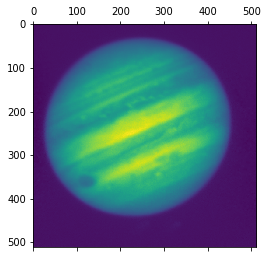

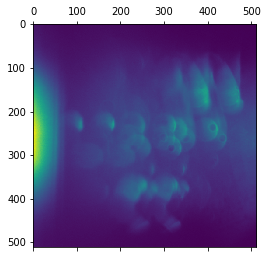

In [10]:
# plot some raw data if you feel like it
plt.matshow(fits.open(directory+jupiter[15])[0].data)
plt.matshow(fits.open(directory+jupiter[150])[0].data)
plt.show()

In [ ]:
# flats
directory = '/Users/dahlek/Desktop/march2017/flats/'
imlist = np.loadtxt('/Users/dahlek/Desktop/march2017/flatlist',dtype=str)
for i in range(0,len(imlist)):
    im = fits.open(directory+imlist[i])
    print imlist[i],im[0].header['lambda'],im[0].header['rfon']

In [ ]:
im = fits.open('/Users/dahlek/Desktop/march2017/jupiter/NC0000179196.FIT')
plt.matshow(im[0].data)
plt.colorbar()
plt.show()

In [ ]:
imfringe = fits.open('/Users/dahlek/Desktop/March_2017_data_Synthetic_fringe_files/Jupiter/NC0000179196.FIT')
plt.matshow(imfringe[0].data)
plt.colorbar()
plt.show()

In [ ]:
plt.matshow(im[0].data/imfringe[0].data)
plt.colorbar()
plt.show()

In [ ]:
def sat_check(directory,images,pixels):
    
    #images = '/home/users/dahlek/NAIC/cube_lists/feb_2017' #*location and list of images to check*
    #directory = '/zenith-data/dahlek/raw_data/2017-02-02/' #*data directory where fits files are*
    #pixels = '/zenith-data/dahlek/' #location and text file of pixel mask.*
    
    #sat_value = 43836. #from linearity_tests.ipynb VALUE FOR OLD CAMERA, PRE-JAN 2018 DATA!
    #sat_value = 27073. #3-sigma VALUE FOR NEW CAMERA
    #sat_value = 30000. #test value
    sat_value = 30400 #5 sigma value for new camera
    max_pixels_rfon = 6000 #from Paul's thesis
    max_pixels_rfoff = 10 #from Paul's thesis

    sat_images_rfon = []
    sat_images_rfoff = []
    number_of_rfoffs = []
    number_of_rfons = []
    unbinned = []

    imlist = np.loadtxt(images,dtype=str) #load the images to look at
    pixel_mask = np.loadtxt(pixels,dtype=int) #Array of positions of hot pixels (Don't count)

    for i in range(0,len(imlist)):

        sat_pix = []
        im = fits.open(directory+imlist[i])
        data = im[0].data
        header = im[0].header
        rf = header['rfon']
        if len(data) == 1024:
            unbinned.append(1)
            continue

        if rf == 1: #If RF is on, check if there are more than 6000 nonlinear pixels. 
            #Right here, put qualifiers for being within a certain position on the sky
            number_of_rfons.append(1)
            for x in range(0,len(im[0].data)):
                for j in range(0,len(im[0].data[x])):
                    #Qualifier to ignore bad pixels:
                    if pixel_mask[x][j] == 1:
                        continue
                    #If it's not a hot pixel, is it greater than the sat_value? If so, append a count
                    elif im[0].data[x][j] > sat_value:
                        sat_pix.append(1)       
            if len(sat_pix) >= max_pixels_rfon:
                #print 'There are more than 10 saturated pixels in',imlist[i]
                sat_images_rfon.append(imlist[i])


        else: #RF is off
            number_of_rfoffs.append(1)
            for x in range(0,len(im[0].data)):
                for j in range(0,len(im[0].data[x])):
                    #Qualifier to ignore bad pixels:
                    if pixel_mask[x][j] == 1:
                        continue
                    #If it's not a hot pixel, is it greater than the sat_value? If so, append a count
                    elif im[0].data[x][j] > sat_value:
                        sat_pix.append(1)
            if len(sat_pix) >= max_pixels_rfoff:
                sat_images_rfoff.append(imlist[i])

        #Save number of sat pixels to header
        header['SAT_VAL'] = (sat_value,'Saturation level (DN)')
        header['SAT_PIX'] = (len(sat_pix),'Number of pixels above saturation level')
        im.writeto(directory+imlist[i],overwrite=True)
        im.close()


    print 'There were '+str(len(imlist))+' images total in '+directory
    print 'There were '+str(len(sat_images_rfoff))+' saturated RF-off images:'
    print sat_images_rfoff
    print 'There were '+str(len(sat_images_rfon))+' saturated RF-on images:'
    print sat_images_rfon
    print 'There were',str(len(unbinned)),'unbinned images that weren\'t analyzed.'